# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **XGBoost** et **SHAP**.

# <span style="color:red"> 🏷️ Étape 4 - CLASSIFICATION AVANCÉE AVEC GESTION DU DÉSÉQUILIBRE</span>


# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [114]:
# ##############################################################################
# ENVIRONNEMENT DE DÉVELOPPEMENT ET CALCUL NUMÉRIQUE
# ##############################################################################
import os                                     # Interface système de fichiers
import time                                   # Mesure des temps d'exécution
import warnings                               # Gestion des alertes (filtres)
import numpy              as np               # Algèbre linéaire et tableaux
import pandas             as pd               # Analyse et structures de données
import matplotlib.pyplot  as plt              # Bibliothèque de traçage de base
import seaborn            as sns              # Visualisation statistique avancée

from collections          import Counter
from pathlib              import Path         # Manipulation moderne de chemins
from typing               import (            # Support du typage statique
    Dict, Tuple, List, Any, Optional, Union
)

# Configuration globale des alertes
warnings.filterwarnings('ignore')             # Nettoyage de la sortie console

# ##############################################################################
# SCIKIT-LEARN : INFRASTRUCTURE ET VALIDATION
# ##############################################################################
from sklearn.model_selection import (
    train_test_split,                         # Division train/test des données
    cross_validate,                           # Évaluation par validation croisée
    StratifiedKFold                           # Découpage stratifié des plis (folds)
)

# ##############################################################################
# SCIKIT-LEARN : MODÈLES ET ALGORITHMES
# ##############################################################################
from sklearn.dummy        import DummyClassifier    # Modèle de référence (Baseline)
from sklearn.linear_model import LogisticRegression # Modèle linéaire classique
from sklearn.ensemble     import (
    RandomForestClassifier,                   # Forêts d'arbres décisionnels
    GradientBoostingClassifier                # Boosting d'arbres standard
)

# ##############################################################################
# SCIKIT-LEARN : MÉTRIQUES DE PERFORMANCE
# ##############################################################################
from sklearn.metrics      import (
    make_scorer,                              # Création de fonctions de score
    classification_report,                    # Rapport de synthèse par classe
    confusion_matrix,                         # Matrice d'erreurs de prédiction
    accuracy_score,                           # Taux de prédiction correcte
    precision_score,                          # Pureté des prédictions positives
    recall_score,                             # Capacité de détection des positifs
    f1_score,                                 # Équilibre Précision/Rappel
    fbeta_score,                               # 
    roc_auc_score,                            # Score de discrimination (AUC)
    roc_curve,                                # Points de la courbe ROC
    auc,                                      # Calcul de l'aire sous la courbe
    precision_recall_curve,                   # Points de la courbe PR
    average_precision_score,                  # Moyenne de précision (AP)
    matthews_corrcoef,                        # Coefficient de corrélation MCC
    cohen_kappa_score                         # Indice de fiabilité Kappa
)

# ##############################################################################
# LIBRAIRIES DE BOOSTING AVANCÉES (GESTION DES DÉPENDANCES)
# ##############################################################################
try:
    from xgboost import XGBClassifier         # Algorithme Extreme Gradient Boosting
    XGBOOST_AVAILABLE = True                  # Indicateur de présence XGBoost
except ImportError:
    XGBOOST_AVAILABLE = False                 # Gestion si librairie manquante

try:
    from catboost import CatBoostClassifier   # Algorithme Gradient Boosting (Categorical)
    CATBOOST_AVAILABLE = True                 # Indicateur de présence CatBoost
except ImportError:
    CATBOOST_AVAILABLE = False                # Gestion si librairie manquante

# ##############################################################################
# RAPPORT DES VERSIONS ET CONFIGURATION INITIALE
# ##############################################################################

print("\n============================================================================")
print("AUDIT DE L'ENVIRONNEMENT DE MODÉLISATION")
print("============================================================================")
print(f"  Version Pandas......: {pd.__version__}")
print(f"  Version Numpy.......: {np.__version__}")
print(f"  XGBoost disponible..: {'✅ OUI' if XGBOOST_AVAILABLE else '❌ NON'}")
print(f"  CatBoost disponible.: {'✅ OUI' if CATBOOST_AVAILABLE else '❌ NON'}")
print("-" * 80)



AUDIT DE L'ENVIRONNEMENT DE MODÉLISATION
  Version Pandas......: 2.3.3
  Version Numpy.......: 2.2.2
  XGBoost disponible..: ✅ OUI
  CatBoost disponible.: ✅ OUI
--------------------------------------------------------------------------------


### Installation de CatBoost

In [115]:
import sys
print(sys.version)

3.12.12 (main, Jan 14 2026, 19:30:21) [MSC v.1944 64 bit (AMD64)]


# Réinstaller pip via le module ensurepip :
!{sys.executable} -m ensurepip --upgrade

# Mise à jour de pip
!{sys.executable} -m pip install --upgrade pip

# Installation du package CatBoost via le gestionnaire pip
!{sys.executable} -m pip install catboost

# Installation du package imbalanced

# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [116]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
PREPROCESED_DIR  = Path("../data/processed")
REPORTS_DIR      = Path("../reports")
MODELS_DIR       = Path("../models/V2")                # Use a folder for each Version 


MODEL_DummyClassifier              = 'Baseline_Dummy'
MODEL_LogisticRegression           = 'LogisticReg_Balanced'
MODEL_RandomForestClassifier       = 'RandomForest_Balanced'
MODEL_GradientBoostingClassifier   = 'GradientBoosting'
MODEL_XGBClassifier                = 'XGBoost_Scaled'
MODEL_RandomForestClassifier_SMOTE = 'RF_SMOTE'


# ============================================================================
# CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET           = "attrition_binary"
FEATURE_TARGET_INITIAL   = "a_quitte_l_entreprise"

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si il y a beaucoup de lignes, on peut contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...........: {FEATURE_TARGET}")
print(f"  Variable cible iniital (Target)...: {FEATURE_TARGET_INITIAL}")
print("  Status............................: ✅ Configuration prête")
print("============================================================================")



PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...........: attrition_binary
  Variable cible iniital (Target)...: a_quitte_l_entreprise
  Status............................: ✅ Configuration prête


## ❇️ LOAD AND EXPLORE DATASET MERGED

In [117]:
# 1. Chargement des fichiers
input_path = PREPROCESED_DIR / "data_final.csv"
df_final    = pd.read_csv(input_path )
print(df_final.info())                                       # Vérification des types Dtype (int, float, object)
display(df_final.head(3))   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   n_log__revenu_mensuel                             1470 non-null   float64
 1   n_log__annee_experience_totale                    1470 non-null   float64
 2   n_log__annees_dans_l_entreprise                   1470 non-null   float64
 3   n_log__annees_depuis_la_derniere_promotion        1470 non-null   float64
 4   n_std__age                                        1470 non-null   float64
 5   n_std__nombre_experiences_precedentes             1470 non-null   float64
 6   n_std__annees_dans_le_poste_actuel                1470 non-null   float64
 7   n_std__satisfaction_employee_environnement        1470 non-null   float64
 8   n_std__note_evaluation_precedente                 1470 non-null   float64
 9   n_std__satisfaction

,n_log__revenu_mensuel,n_log__annee_experience_totale,n_log__annees_dans_l_entreprise,n_log__annees_depuis_la_derniere_promotion,n_std__age,n_std__nombre_experiences_precedentes,n_std__annees_dans_le_poste_actuel,n_std__satisfaction_employee_environnement,n_std__note_evaluation_precedente,n_std__satisfaction_employee_nature_travail,...,c_ohe__domaine_etude_Autre,c_ohe__domaine_etude_Entrepreunariat,c_ohe__domaine_etude_Infra & Cloud,c_ohe__domaine_etude_Marketing,c_ohe__domaine_etude_Ressources Humaines,c_ohe__domaine_etude_Transformation Digitale,c_ohe__frequence_deplacement_Aucun,c_ohe__frequence_deplacement_Frequent,c_ohe__frequence_deplacement_Occasionnel,attrition_binary
0,0.218262,-0.148970,0.178857,-0.974295,0.446350,2.125136,-0.063296,-0.660531,0.379672,1.153254,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,-0.017266,0.144921,0.777704,-0.116765,1.322365,-0.678049,0.764998,0.254625,-1.026167,-0.660853,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-1.377263,-0.321469,-2.399329,-0.974295,0.008343,1.324226,-1.167687,1.169781,-1.026167,0.246200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


## ⬇️ Import Classe auxiliare pour analyse (DataCleaner)

In [118]:
# ==================================================================================================
# INITIALISATION DU MOTEUR DE NETTOYAGE (DATA CLEANING)
# ==================================================================================================

# Importation de la classe personnalisée d'ingénierie des données
# Cette classe encapsule les règles métier spécifiques au dataset de Seattle.
from DataCleaner  import DataCleaner                # Module de nettoyage propriétaire

# Initialisation du nettoyeur global
# verbose=True permet d'éditer un rapport détaillé des transformations effectuées.
cleaner           = DataCleaner(
                           df      = df_final,      # Source des données brutes
                           verbose = True              # Activation des logs détaillés
)

# --------------------------------------------------------------------------------------------------
# RAPPORT D'ÉTAT DU NETTOYEUR
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("INSTANCIATION DU MOTEUR DE NETTOYAGE")
print("==================================================================================================")
print(f"  Objet créé............: {type(cleaner).__name__}")
print(f"  Mode verbeux..........: Activé (Diagnostic temps réel)")
print(f"  Source de données.....: dataset_raw (ID: {id(df_final)})")
print(f"  Statut................: ✅ Prêt pour l'étape de transformation")
print("==================================================================================================\n")


INSTANCIATION DU MOTEUR DE NETTOYAGE
  Objet créé............: DataCleaner
  Mode verbeux..........: Activé (Diagnostic temps réel)
  Source de données.....: dataset_raw (ID: 1623713946880)
  Statut................: ✅ Prêt pour l'étape de transformation



## ⬇️ Import Classe auxiliare pour modelisation (ClassificationModeler)

In [119]:
from ClassificationModeler import ClassificationModeler

# 🎯 ANALYSE DU CONTEXTE MÉTIER

**Type de problème : Prédiction d'attrition (démission)**
- **Classe positive (1)** : Employé a quitté l'entreprise
- **Classe négative (0)** : Employé reste dans l'entreprise

**Enjeux métier critiques :**

| Type d'erreur | Impact business | Coût |
|---------------|-----------------|------|
| **Faux Positif (FP)** | Identifier à tort un employé comme "à risque" → Actions RH inutiles, stress inutile | **MODÉRÉ** (50-200€) |
| **Faux Négatif (FN)** | Ne pas détecter un employé qui va partir → Perte de talent, coût de recrutement/formation | **ÉLEVÉ** (5000-15000€) |

**⚠️ CONCLUSION : Les FN coûtent 25-75× plus cher que les FP**


## ✂️ SPLIT: TARGER et FEATURES

In [120]:
# Rien a suprimer, le dataset est deja pret.
cleaner.FEATURES_TO_REMOVE  =  []

# Appel de ta fonction
X_prep, y_prep   = cleaner.pipeline_preparation_initiale( df           = cleaner.df, 
                                                          target       = FEATURE_TARGET, 
                                                          cols_to_drop = cleaner.FEATURES_TO_REMOVE
                                                         )


--- Nettoyage des colonnes ---
------------------------------------------------------------
🎯 CIBLE (y)      : attrition_binary
🧬 FEATURES (X)   : ['n_log__revenu_mensuel', 'n_log__annee_experience_totale', 'n_log__annees_dans_l_entreprise', 'n_log__annees_depuis_la_derniere_promotion', 'n_std__age', 'n_std__nombre_experiences_precedentes', 'n_std__annees_dans_le_poste_actuel', 'n_std__satisfaction_employee_environnement', 'n_std__note_evaluation_precedente', 'n_std__satisfaction_employee_nature_travail', 'n_std__satisfaction_employee_equipe', 'n_std__satisfaction_employee_equilibre_pro_perso', 'n_std__note_evaluation_actuelle', 'n_std__heure_supplementaires', 'n_std__augementation_salaire_precedente', 'n_std__nombre_participation_pee', 'n_std__nb_formations_suivies', 'n_std__distance_domicile_travail', 'n_std__niveau_education', 'n_std__annes_sous_responsable_actuel', 'c_ohe__genre_F', 'c_ohe__genre_M', 'c_ohe__statut_marital_Célibataire', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__

## ⚖️ ANALYSE DU DÉSÉQUILIBRE

In [121]:
print("="*80)
print("📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("="*80)

# Supposons que on a déjà préparé X et y
# X = votre DataFrame avec les 25 features
# y = votre Series 'attrition_binary'

print(f"\n🔍 Distribution de la cible (attrition_binary):")
print(y_prep.value_counts())
print(f"\n📊 Distribution relative:")
print(y_prep.value_counts(normalize=True))

ratio_desequilibre = y_prep.value_counts().max() / y_prep.value_counts().min()
print(f"\n⚠️ Ratio de déséquilibre: {ratio_desequilibre:.2f}:1")
print(f"   SMOTE Counter y_train_smote: {Counter(y_prep)}")


📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES

🔍 Distribution de la cible (attrition_binary):
attrition_binary
0    1233
1     237
Name: count, dtype: int64

📊 Distribution relative:
attrition_binary
0    0.838776
1    0.161224
Name: proportion, dtype: float64

⚠️ Ratio de déséquilibre: 5.20:1
   SMOTE Counter y_train_smote: Counter({0: 1233, 1: 237})


## 📊 **STRATÉGIE DE MODÉLISATION RECOMMANDÉE**

**1️⃣ Méthodologie de découpage (Split Strategy)**

```python
from sklearn.model_selection import train_test_split, StratifiedKFold

# ✅ APPROCHE RECOMMANDÉE : Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,           # 75% train, 25% test
    stratify=y,               # ⚠️ OBLIGATOIRE pour préserver la distribution
    random_state=42           # Reproductibilité
)

# ✅ Validation croisée STRATIFIÉE (pour évaluation robuste)
cv_strategy = StratifiedKFold(
    n_splits=5,               # 5 folds
    shuffle=True,             # Mélange des données
    random_state=42
)
```

**Pourquoi cette approche ?**
- ✅ Préserve la proportion des classes dans train/test
- ✅ Évite les biais si le dataset est déséquilibré
- ✅ Validation croisée stratifiée = meilleure estimation de la généralisation


In [122]:
if ratio_desequilibre > 3:
    print("   → Déséquilibre FORT : SMOTE + class_weight recommandé")
    strategie_recommandee = "aggressive"
elif ratio_desequilibre > 1.5:
    print("   → Déséquilibre MODÉRÉ : class_weight='balanced' suffit")
    strategie_recommandee = "balanced"
else:
    print("   → Déséquilibre FAIBLE : approche standard OK")
    strategie_recommandee = "standard"

   → Déséquilibre FORT : SMOTE + class_weight recommandé


## **📐 Identification des Métriques d'évaluation prioritaires**

Étant donné que **les FN coûtent très cher** en RH :

| Métrique | Priorité | Pourquoi ? |
|----------|----------|------------|
| **Recall** 🔥 | **HAUTE** | Capturer tous les employés à risque (minimiser FN) |
| **Précision-Recall AUC** 🔥 | **HAUTE** | Meilleure que ROC-AUC pour classes déséquilibrées |
| **F1-Score** | MOYENNE | Équilibre, mais pas optimal si coût FN >> FP |
| **F-beta (β=2)** 🎯 | **RECOMMANDÉ** | Pénalise 2× plus les FN que les FP |
| **Courbe PR** | HAUTE | Pour optimiser le seuil selon le contexte |
| **MCC** | MOYENNE | Robustesse globale |
| **ROC-AUC** | ⚠️ BASSE | Trompeuse avec déséquilibre |

### Deéclaration des Métriques d'évaluation prioritaires

**3️⃣ Configuration complète pour la ClassificationModeler**## 📋 **RÉSUMÉ DES FONCTIONS SKLEARN UTILISÉES**

| Fonction | Usage | Pourquoi ? |
|----------|-------|------------|
| `train_test_split(..., stratify=y)` | Split stratifié | ✅ Préserve la distribution des classes |
| `StratifiedKFold(n_splits=5)` | Validation croisée | ✅ Évaluation robuste avec stratification |
| `make_scorer(fbeta_score, beta=2)` | Métrique personnalisée | ✅ Pénalise 2× plus les FN que les FP |
| `class_weight='balanced'` | Gestion déséquilibre | ✅ Ajuste automatiquement les poids |
| `scale_pos_weight` (XGBoost) | Alternative XGBoost | ✅ Équivalent de class_weight |
| `precision_recall_curve()` | Optimisation seuil | ✅ Trouve le seuil optimal selon le métier |

**Gestion du déséquilibre**

| Modèle | Paramètre d'Équilibrage | Fonctionnement Technique |
| --- | --- | --- |
| **Régression Logistique** | `class_weight='balanced'` | Modifie la **fonction de coût** pour pénaliser davantage les erreurs sur la classe minoritaire. |
| **Random Forest** | `class_weight='balanced'` | Ajuste le poids des classes lors du calcul de l'impureté (Gini/Entropie) dans **chaque nœud** de l'arbre. |
| **Gradient Boosting** | **Aucun** (⚠️) | Ignore le déséquilibre par défaut ; il se concentre uniquement sur la réduction résiduelle des erreurs. |
| **XGBoost** | `scale_pos_weight` | Applique un facteur d'échelle au **gradient** de la classe positive (ce qui accélère sa correction). |
| **RF + SMOTE** | **Manuel (Rééchantillonnage)** | Crée de **nouvelles données synthétiques** pour la classe 1 avant de lancer l'entraînement. |


🎯 **CHECKLIST FINALE**

- ✅ **Split stratifié** avec `train_test_split(stratify=y)`
- ✅ **Validation croisée stratifiée** avec `StratifiedKFold`
- ✅ **Métriques adaptées** : F2-Score, Recall prioritaire
- ✅ **Gestion déséquilibre** : `class_weight='balanced'`
- ✅ **Optimisation du seuil** via courbe Précision-Rappel
- ✅ **Interprétation métier** : Coûts FP=150€ vs FN=10000€
- ✅ **Comparaison multi-modèles** : Baseline → Linéaire → Non-linéaires



In [123]:
# 🎯 MÉTRIQUES PERSONNALISÉES POUR LE CONTEXTE RH
# Priorité : MAXIMISER LE RECALL (détecter tous les employés à risque)

CUSTOM_METRICS = {
    # Métriques standards
    'accuracy' : 'accuracy',
    'precision': make_scorer(precision_score , average='binary', zero_division=0),
    'recall'   : make_scorer(recall_score    , average='binary', zero_division=0),
    'f1'       : make_scorer(f1_score        , average='binary', zero_division=0),
    
    # ⚠️ MÉTRIQUE PRIORITAIRE : F-beta avec β=2
    # β=2 pénalise 2× plus les faux négatifs que les faux positifs
    'f2'       : make_scorer(fbeta_score     , average='binary', zero_division=0, beta=2  ),
    
    # Métriques avancées
    'roc_auc'  : 'roc_auc',
    'log_loss' : 'neg_log_loss'
}

print("\n🎯 Métriques configurées :")
print("   ✓ Accuracy (référence générale)")
print("   ✓ Precision (fiabilité des alertes)")
print("   ✓ Recall (capture des employés à risque) 🔥 PRIORITÉ")
print("   ✓ F1-Score (équilibre standard)")
print("   ✓ F2-Score (favorise le recall) 🎯 RECOMMANDÉ")
print("   ✓ ROC-AUC (capacité de discrimination)")
print("   ✓ Log-Loss (qualité des probabilités)")

print("\n💡 Recommandation métier :")
print("   → Optimiser le modèle sur le F2-SCORE ou le RECALL")
print("   → Un recall élevé = moins de démissions non détectées")


🎯 Métriques configurées :
   ✓ Accuracy (référence générale)
   ✓ Precision (fiabilité des alertes)
   ✓ Recall (capture des employés à risque) 🔥 PRIORITÉ
   ✓ F1-Score (équilibre standard)
   ✓ F2-Score (favorise le recall) 🎯 RECOMMANDÉ
   ✓ ROC-AUC (capacité de discrimination)
   ✓ Log-Loss (qualité des probabilités)

💡 Recommandation métier :
   → Optimiser le modèle sur le F2-SCORE ou le RECALL
   → Un recall élevé = moins de démissions non détectées


# ✂️ Step 1.SPLIT: Méthodologie de découpage (Split Strategy)

In [124]:
# ✅ UTILISATION DE train_test_split AVEC STRATIFICATION
X_train, X_test, y_train, y_test = train_test_split(
    X_prep, y_prep,
    test_size=0.25,           # 25% pour le test (règle standard)
    stratify=y_prep,          # ⚠️ CRUCIAL : préserve la distribution des classes
    random_state=42,          # Reproductibilité
    shuffle=True              # Mélange avant split
)

print("\n============================================================================")
print("BILAN DU PARTITIONNEMENT (Split stratifié)")
print("============================================================================")
print(f"\n✅ Split réalisé avec succès :")
print(f"   • Train.....................: {X_train.shape[0]:,} échantillons ({X_train.shape[0]/len(X_prep)*100:.1f}%)")
print(f"   • Test......................:  {X_test.shape[0]:,} échantillons ({X_test.shape[0]/len(X_prep)*100:.1f}%)")
print(f"  Variables prédictives........: {X_train.shape[1]}")

print(f"\n📊 Vérification de la stratification :")
print(f"   Dataset complet............: {y_prep.value_counts(normalize=True).to_dict()}")
print(f"   Train set..................: {y_train.value_counts(normalize=True).to_dict()}")
print(f"   Test set...................: {y_test.value_counts(normalize=True).to_dict()}")



BILAN DU PARTITIONNEMENT (Split stratifié)

✅ Split réalisé avec succès :
   • Train.....................: 1,102 échantillons (75.0%)
   • Test......................:  368 échantillons (25.0%)
  Variables prédictives........: 43

📊 Vérification de la stratification :
   Dataset complet............: {0: 0.8387755102040816, 1: 0.16122448979591836}
   Train set..................: {0: 0.838475499092559, 1: 0.16152450090744103}
   Test set...................: {0: 0.8396739130434783, 1: 0.16032608695652173}


## ⭐ FEATURE ENGINEERING


| Nom de la Feature | Formule Mathématique | Définition & Logique Métier |
| --- | --- | --- |
| **`fe1_ratio_stagnation`** | $\frac{\text{Promotions}}{\text{Ancienneté} + 1}$ | **Score de Stagnation** : Mesure la proportion de la carrière dans l'entreprise passée sans promotion. Un score élevé indique un blocage de carrière. |
| **`fe2_stabilite_manager`** | $\frac{\text{Années sous Responsable}}{\text{Années Poste Actuel} + 1}$ | **Lassitude Managériale** : Si proche de 1, l'employé n'a pas changé de manager malgré son ancienneté dans le poste, ce qui peut freiner le renouvellement des idées. |
| **`fe3_indice_job_hopping`** | $\frac{\text{Expérience Totale}}{\text{Nb Entreprises Précédentes} + 1}$ | **Indice "Zappeur"** : Un score bas indique un profil qui change très souvent d'entreprise (instabilité chronique). |
| **`fe4_anciennete_relative`** | $\frac{\text{Ancienneté Entreprise}}{\text{Âge} - 18}$ | **Fidélité Relative** : Proportion de la vie active passée au sein de l'organisation. Mesure l'attachement historique de l'employé à l'entreprise. |
| **`fe5_satisfaction_globale`** | $mean(\text{Satisfaction\_cols})$ | **Vision Holistique** : Moyenne agrégée des scores de satisfaction (environnement, travail, équipe, équilibre). Donne l'état moral général du salarié. |
| **`fe6_risque_overwork`** | $\text{Heures Sup} \times \frac{1}{\text{Équilibre Pro} + 2}$ | **Risque de Burn-out** : Combine une forte charge de travail avec un mauvais équilibre vie pro/vie perso. C'est un indicateur de tension extrême. |
| **`fe7_penibilite_trajet`** | $\text{Heures Sup} \times \text{Distance Domicile}$ | **Pénibilité Logistique** : Cumul de la fatigue liée aux heures supplémentaires et de la distance géographique. Facteur de lassitude physique. |
| **`fe8_valeur_experience`** | $\frac{\text{Revenu Mensuel}}{\text{Expérience Totale} + 1}$ | **Équité Perçue** : Analyse si le salaire est à la hauteur de l'expérience globale du salarié. Un ratio bas peut générer un sentiment d'injustice salariale. |


In [125]:
def appliquer_feature_engineering(df):
    """
    Enrichit le dataset avec des variables métier calculées (Ratios RH).
    Expertise : Focus sur la stagnation, la fidélité et la pénibilité.
    """
    # Création d'une copie pour éviter les SettingWithCopyWarning
    df = df.copy()

    # -------------------------------------------------------------------------
    # --- 1. RATIOS DE CARRIÈRE ET DE STAGNATION ---
    # Score élevé = Sentiment de stagnation
    # Logique : Un score élevé indique qu'un employé a passé une grande partie de son temps dans l'entreprise sans promotion.
    df['fe1_ratio_stagnation'] = (
        df['n_log__annees_depuis_la_derniere_promotion'] / (df['n_log__annees_dans_l_entreprise'] + 1)
    )
    
    # Proche de 1 = Lassitude managériale possible
    # Logique : Si ce ratio est proche de 1, l'employé n'a pas changé de manager malgré son ancienneté, ce qui peut créer une lassitude.
    df['fe2_stabilite_manager'] = (
        df['n_std__annes_sous_responsable_actuel'] / (df['n_std__annees_dans_le_poste_actuel'] + 1)
    )

    # -------------------------------------------------------------------------
    # --- 2. INDICATEURS DE STABILITÉ PROFESSIONNELLE ---
    # Score bas = Profil "Zappeur" (Job Hopper)
    # Logique : Plus le score est bas, plus l'employé a tendance à changer souvent d'entreprise (profil instable).
    df['fe3_indice_job_hopping'] = (
        df['n_log__annee_experience_totale'] / (df['n_std__nombre_experiences_precedentes'] + 1)
    )
    
    # Proportion de la vie active passée dans l'entreprise (Hypothèse début carrière à 18 ans)
    # On s'assure que le dénominateur ne soit pas <= 0
    # Logique : Quelle proportion de sa vie active l'employé a-t-elle passée dasn cette enterprise ?
    age_actif = (df['n_std__age'] - 18).clip(lower=1)
    df['fe4_anciennete_relative'] = df['n_log__annees_dans_l_entreprise'] / age_actif

    # -------------------------------------------------------------------------
    # --- 3. SCORES DE SATISFACTION AGRÉGÉS ET INTERACTIONS ---
    # Vision holistique de la satisfaction
    # Somme des 4 colonnes de satisfaction
    cols_satisfaction = [c for c in df.columns if 'satisfaction_employee' in c]
    df['fe5_satisfaction_globale'] = df[cols_satisfaction].mean(axis=1)
    
    # Zone rouge : Heures sup + Mauvais équilibre perso/pro
    # On utilise l'inverse de la satisfaction équilibre si on veut un score de "risque"
    df['fe6_risque_overwork'] = (
        df['n_std__heure_supplementaires'] * (1 / (df['n_std__satisfaction_employee_equilibre_pro_perso'] + 2))
    )

    # Option alternative plus simple (Soustraction) :
    # On part du principe que n_std est normalisé (moyenne 0). 
    # Si Heures Sup est positif et Equilibre est négatif, le risque augmente.
    # df['fe_risque_overwork'] = df['n_std__heure_supplementaires'] - df['n_std__satisfaction_employee_equilibre_pro_perso']
    
    # -------------------------------------------------------------------------
    # Pénibilité physique/logistique
    df['fe7_penibilite_trajet'] = (
        df['n_std__heure_supplementaires'] * df['n_std__distance_domicile_travail']
    )

    # --- 4. RATIOS DE RÉMUNÉRATION ---
    # Équité perçue selon l'expérience
    # Logique : L'employé est-il payé à sa juste valeur par rapport à son bagage ?
    df['fe8_valeur_experience'] = (
        df['n_log__revenu_mensuel'] / (df['n_log__annee_experience_totale'] + 1)
    )

    return df
    
# Application au Train et au Test
print(f"✅ Features avant (X_train)......: {X_train.shape[1]} colonnes")
cols_avant         = X_train.columns.tolist()

X_train            = appliquer_feature_engineering(X_train)
X_test             = appliquer_feature_engineering(X_test)

cols_apres         = X_train.columns.tolist()
nouvelles_features = [c for c in cols_apres if c not in cols_avant]

print(f"✅ Features avant (X_train)......: {len(cols_avant)} colonnes")
print(f"✅ Features après (X_train)......: {len(cols_apres)} colonnes")
print(f"✅ Nouvelles Features ({len(nouvelles_features)})......: {nouvelles_features}")


✅ Features avant (X_train)......: 43 colonnes
✅ Features avant (X_train)......: 43 colonnes
✅ Features après (X_train)......: 51 colonnes
✅ Nouvelles Features (8)......: ['fe1_ratio_stagnation', 'fe2_stabilite_manager', 'fe3_indice_job_hopping', 'fe4_anciennete_relative', 'fe5_satisfaction_globale', 'fe6_risque_overwork', 'fe7_penibilite_trajet', 'fe8_valeur_experience']


# 🔗 Step 2. INITIALISATION DU CLASSIFICATION MODELER

In [126]:
# Initialisation du Modélisateur. Instanciar el Modeler
# El print de inicialización te dará el resumen de la configuración automáticamente
# --------------------------------------------------------------------------
modeler = ClassificationModeler(X_train , y_train, X_test, y_test)

print("\n" + "="*80)
print("🚀 INITIALISATION DU CLASSIFICATION MODELER")
print("="*80)

modeler = ClassificationModeler(
    X_train =X_train,
    y_train =y_train,
    X_test  =X_test,
    y_test  =y_test,
    config={
        'CV_FOLDS'    : 5,              # Validation croisée sur 5 folds
        'RANDOM_STATE': 42,              # Reproductibilité
        'METRICS'     : CUSTOM_METRICS,  # Nos métriques personnalisées
        'THRESHOLD'   : 0.5              # Seuil par défaut (on l'optimisera)
    }
)

print("\n✅ ClassificationModeler initialisé avec succès")


🎯 CLASSIFICATION MODELER INITIALISÉ
  Samples Train.......: 1102
  Features Train......: 51
  Samples Test........: 368

  DISTRIBUTION DES CLASSES (TRAIN) :
    Classe 0..........: 83.85%
    Classe 1..........: 16.15%

  DISTRIBUTION DES CLASSES (TEST) :
    Classe 0..........: 83.97%
    Classe 1..........: 16.03%

  ⚠️  DATASET DÉSÉQUILIBRÉ (Ratio 5.19:1)
     Conseil : Utiliser class_weight='balanced' dans vos modèles

  Random State........: 42
  CV Folds (Stratified): 5
  Seuil de Décision...: 0.5
  Métriques actives...: ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc', 'log_loss']


🚀 INITIALISATION DU CLASSIFICATION MODELER

🎯 CLASSIFICATION MODELER INITIALISÉ
  Samples Train.......: 1102
  Features Train......: 51
  Samples Test........: 368

  DISTRIBUTION DES CLASSES (TRAIN) :
    Classe 0..........: 83.85%
    Classe 1..........: 16.15%

  DISTRIBUTION DES CLASSES (TEST) :
    Classe 0..........: 83.97%
    Classe 1..........: 16.03%

  ⚠️  DATASET DÉSÉQUILIBRÉ (

# ⏳ Step 3. Entraînements Individuels

## 🏋️‍♂️ Training Dummy Model

In [127]:
# --------------------------------------------------------------------------
# Baseline : Modèle aléatoire stratifié
# modeler.entrainer_modele(  DummyClassifier(strategy='stratified'), 
#                           'Baseline_Aleatoire'
#                         )

# ─────────────────────────────────────────────────────────────────────────
# 1️⃣ BASELINE : Modèle Dummy (référence minimale)
# ─────────────────────────────────────────────────────────────────────────
print("\n📊 [1/6] Entraînement du modèle BASELINE...")
modeler.entrainer_modele(
    modele=DummyClassifier(strategy='stratified', random_state=42),
    nom_modele='Baseline_Dummy',
    verbeux=True
)


📊 [1/6] Entraînement du modèle BASELINE...

🎯 EXPÉRIENCE #1 : Baseline_Dummy

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.7307 (±0.0080) | CV: 0.7323 (±0.0171)
   PRECISION  → Train: 0.1750 (±0.0262) | CV: 0.1455 (±0.0588)
   RECALL     → Train: 0.1797 (±0.0270) | CV: 0.1348 (±0.0537)
   F1         → Train: 0.1773 (±0.0266) | CV: 0.1399 (±0.0561)
   F2         → Train: 0.1787 (±0.0268) | CV: 0.1368 (±0.0546)
   ROC_AUC    → Train: 0.5083 (±0.0158) | CV: 0.4911 (±0.0320)
   LOG_LOSS   → Train: 9.7061 (±0.2870) | CV: 9.6479 (±0.6155)

🏋️  Entraînement sur 1102 échantillons...
   ✅ Complété en 0.00s

🔮 Génération des prédictions...
   Train - Classe positive: 16.79%
   Test  - Classe positive: 15.76%

✅ Généralisation optimale (pas d'overfitting)

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (Baseline_Dummy)
──────────────────────────────────────────────────────────────────────
              pre

{'id_experience': 1,
 'nom_modele': 'Baseline_Dummy',
 'modele': DummyClassifier(random_state=42, strategy='stratified'),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.7307133977313968),
   'train_ecart': np.float64(0.007963614611422719),
   'cv_moyenne': np.float64(0.7323282599753188),
   'cv_ecart': np.float64(0.017076081820066362)},
  'precision': {'train_moyenne': np.float64(0.1750100739398263),
   'train_ecart': np.float64(0.0261981258661735),
   'cv_moyenne': np.float64(0.14545454545454545),
   'cv_ecart': np.float64(0.05875975584747065)},
  'recall': {'train_moyenne': np.float64(0.17969073180340786),
   'train_ecart': np.float64(0.027006400896320257),
   'cv_moyenne': np.float64(0.13476190476190478),
   'cv_ecart': np.float64(0.05371180901641249)},
  'f1': {'train_moyenne': np.float64(0.17731920915268265),
   'train_ecart': np.float64(0.026595379380103458),
   'cv_moyenne': np.float64(0.1398976982097187),
   'cv_ecart': np.float64(0.05611620768808594)},
  'f2': {'tra

## 🏋️‍♂️ Training Logistic Regression

In [128]:
# Modèle Linéaire : Régression Logistique
# modeler.entrainer_modele(
#     LogisticRegression(max_iter=1000, class_weight='balanced'), 
#     'Regression_Logistique'
# )

# ─────────────────────────────────────────────────────────────────────────
# 2️⃣ MODÈLE LINÉAIRE : Régression Logistique avec class_weight
# ─────────────────────────────────────────────────────────────────────────
print("\n📊 [2/6] Entraînement RÉGRESSION LOGISTIQUE (class_weight)...")
modeler.entrainer_modele(
    modele=LogisticRegression(
        class_weight='balanced',  # ⚠️ Gère automatiquement le déséquilibre
        max_iter=1000,
        random_state=42,
        solver='liblinear'        # Bon pour datasets moyens
    ),
    nom_modele='LogisticReg_Balanced',
    verbeux=True
)


📊 [2/6] Entraînement RÉGRESSION LOGISTIQUE (class_weight)...

🎯 EXPÉRIENCE #2 : LogisticReg_Balanced

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.8040 (±0.0099) | CV: 0.7786 (±0.0144)
   PRECISION  → Train: 0.4426 (±0.0154) | CV: 0.4003 (±0.0248)
   RECALL     → Train: 0.8189 (±0.0174) | CV: 0.7417 (±0.0472)
   F1         → Train: 0.5746 (±0.0166) | CV: 0.5197 (±0.0297)
   F2         → Train: 0.6998 (±0.0170) | CV: 0.6333 (±0.0367)
   ROC_AUC    → Train: 0.8886 (±0.0076) | CV: 0.8409 (±0.0278)
   LOG_LOSS   → Train: 0.4069 (±0.0136) | CV: 0.4521 (±0.0321)

🏋️  Entraînement sur 1102 échantillons...
   ✅ Complété en 0.03s

🔮 Génération des prédictions...
   Train - Classe positive: 30.67%
   Test  - Classe positive: 24.46%

✅ Généralisation optimale (pas d'overfitting)

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (LogisticReg_Balanced)
──────────────────────────────────────────────────────────

{'id_experience': 2,
 'nom_modele': 'LogisticReg_Balanced',
 'modele': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                    solver='liblinear'),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.8039943786822332),
   'train_ecart': np.float64(0.009871301094995844),
   'cv_moyenne': np.float64(0.7785684903331963),
   'cv_ecart': np.float64(0.01438786193828246)},
  'precision': {'train_moyenne': np.float64(0.44261826438508833),
   'train_ecart': np.float64(0.015364915495115145),
   'cv_moyenne': np.float64(0.40030324567638004),
   'cv_ecart': np.float64(0.024772305613122905)},
  'recall': {'train_moyenne': np.float64(0.8188712695754949),
   'train_ecart': np.float64(0.017446676436731097),
   'cv_moyenne': np.float64(0.7417460317460318),
   'cv_ecart': np.float64(0.04722482319100859)},
  'f1': {'train_moyenne': np.float64(0.5745741706169553),
   'train_ecart': np.float64(0.016601131232344944),
   'cv_moyenne': np.float64(0.519661261385990

## 🏋️‍♂️ Training Random Forest

In [129]:
# Modèle d'Ensemble : Forêt Aléatoire
# modeler.entrainer_modele(
#     RandomForestClassifier(n_estimators=100, class_weight='balanced'), 
#     'Random_Forest'
# )

# ─────────────────────────────────────────────────────────────────────────
# 3️⃣ RANDOM FOREST : Modèle non-linéaire robuste avec class_weight
# ─────────────────────────────────────────────────────────────────────────
print("\n📊 [3/6] Entraînement RANDOM FOREST (class_weight)...")
modeler.entrainer_modele(
    modele=RandomForestClassifier(
        n_estimators=200,         # Nombre d'arbres
        max_depth=10,             # Profondeur maximale (évite overfitting)
        min_samples_split=20,     # Min échantillons pour split
        min_samples_leaf=10,      # Min échantillons par feuille
        class_weight='balanced',  # ⚠️ Pénalise la classe minoritaire
        random_state=42,
        n_jobs=-1                 # Parallélisation
    ),
    nom_modele='RandomForest_Balanced',
    verbeux=True
)


📊 [3/6] Entraînement RANDOM FOREST (class_weight)...

🎯 EXPÉRIENCE #3 : RandomForest_Balanced

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.9220 (±0.0029) | CV: 0.8494 (±0.0128)
   PRECISION  → Train: 0.7204 (±0.0128) | CV: 0.5372 (±0.0413)
   RECALL     → Train: 0.8455 (±0.0190) | CV: 0.5113 (±0.0537)
   F1         → Train: 0.7778 (±0.0083) | CV: 0.5222 (±0.0407)
   F2         → Train: 0.8170 (±0.0131) | CV: 0.5152 (±0.0477)
   ROC_AUC    → Train: 0.9699 (±0.0010) | CV: 0.8039 (±0.0333)
   LOG_LOSS   → Train: 0.3385 (±0.0049) | CV: 0.4289 (±0.0074)

🏋️  Entraînement sur 1102 échantillons...
   ✅ Complété en 0.44s

🔮 Génération des prédictions...
   Train - Classe positive: 18.78%
   Test  - Classe positive: 16.58%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.324

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (RandomForest_Balanced)
─────────────────────────────────────

{'id_experience': 3,
 'nom_modele': 'RandomForest_Balanced',
 'modele': RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=10, min_samples_split=20,
                        n_estimators=200, n_jobs=-1, random_state=42),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.9219586586053264),
   'train_ecart': np.float64(0.0029428504505593193),
   'cv_moyenne': np.float64(0.8493541752365281),
   'cv_ecart': np.float64(0.012767460483398442)},
  'precision': {'train_moyenne': np.float64(0.7204107280027868),
   'train_ecart': np.float64(0.012813637376483158),
   'cv_moyenne': np.float64(0.5371886446886447),
   'cv_ecart': np.float64(0.041297101143641365)},
  'recall': {'train_moyenne': np.float64(0.845543189205161),
   'train_ecart': np.float64(0.019047869548155412),
   'cv_moyenne': np.float64(0.5112698412698412),
   'cv_ecart': np.float64(0.053728224391337426)},
  'f1': {'train_moyenne': np.float64(0.7777504676395115),
   'train_eca

## 🏋️‍♂️ Training Gradient Boosting Classifier

In [130]:
# ─────────────────────────────────────────────────────────────────────────
# 4️⃣ GRADIENT BOOSTING : Alternative puissante
# ─────────────────────────────────────────────────────────────────────────
print("\n📊 [4/6] Entraînement GRADIENT BOOSTING...")
modeler.entrainer_modele(
    modele=GradientBoostingClassifier(
        n_estimators      = 150,
        learning_rate     = 0.1,
        max_depth         = 5,
        min_samples_split = 20,
        min_samples_leaf  = 10,
        random_state      = 42
    ),
    nom_modele = 'GradientBoosting',
    verbeux    = True
)


📊 [4/6] Entraînement GRADIENT BOOSTING...

🎯 EXPÉRIENCE #4 : GradientBoosting

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 1.0000 (±0.0000) | CV: 0.8693 (±0.0066)
   PRECISION  → Train: 1.0000 (±0.0000) | CV: 0.6981 (±0.0523)
   RECALL     → Train: 1.0000 (±0.0000) | CV: 0.3422 (±0.0628)
   F1         → Train: 1.0000 (±0.0000) | CV: 0.4548 (±0.0586)
   F2         → Train: 1.0000 (±0.0000) | CV: 0.3794 (±0.0624)
   ROC_AUC    → Train: 1.0000 (±0.0000) | CV: 0.8007 (±0.0376)
   LOG_LOSS   → Train: 0.0121 (±0.0014) | CV: 0.4255 (±0.0472)

🏋️  Entraînement sur 1102 échantillons...
   ✅ Complété en 2.25s

🔮 Génération des prédictions...
   Train - Classe positive: 16.15%
   Test  - Classe positive: 6.25%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.707
   • Écart Accuracy.: 0.158

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (GradientBoosting)
───────────────────────────────

{'id_experience': 4,
 'nom_modele': 'GradientBoosting',
 'modele': GradientBoostingClassifier(max_depth=5, min_samples_leaf=10,
                            min_samples_split=20, n_estimators=150,
                            random_state=42),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.8693294940353764),
   'cv_ecart': np.float64(0.006648689361216973)},
  'precision': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.6981166150670794),
   'cv_ecart': np.float64(0.052258079006753375)},
  'recall': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.34222222222222226),
   'cv_ecart': np.float64(0.06284471578294594)},
  'f1': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.4548023025341371),
   'cv_ecart': np.float64(0.058585111925329364)},
  'f2': {'train_moye

## 🏋️‍♂️ Training XGBoost 

In [131]:
# 4. Entrenar XGBoost (si está instalado)
# if XGBOOST_AVAILABLE:
#     print("🚀 Entrenando XGBoost...")
#     modeler.entrainer_modele(
#         XGBClassifier(
#             n_estimators     = 100,
#             learning_rate    = 0.1,
#             max_depth        = 6,
#             use_label_encoder = False,
#             eval_metric      = 'logloss',
#             random_state     = 42
#         ),
#         'XGBoost_Advanced'
#     )

# ─────────────────────────────────────────────────────────────────────────
# 5️⃣ XGBOOST : État de l'art avec scale_pos_weight
# ─────────────────────────────────────────────────────────────────────────
print("\n📊 [5/6] Entraînement XGBOOST (scale_pos_weight)...")

# Calcul du ratio pour scale_pos_weight (alternativa similar a class_weight='balanced'
ratio_classes = (y_train == 0).sum() / (y_train == 1).sum()
print(f"   Ratio calculé pour scale_pos_weight: {ratio_classes:.2f}")

modeler.entrainer_modele(
    modele=XGBClassifier(
        n_estimators      = 200,
        max_depth         = 6,
        learning_rate     = 0.05,
        min_child_weight  = 3,
        scale_pos_weight  = ratio_classes,  # ⚠️ Ajuste le déséquilibre
        random_state      = 42,
        use_label_encoder = False,
        eval_metric       = 'logloss',
        n_jobs            = -1
    ),
    nom_modele = 'XGBoost_Scaled',
    verbeux    = True
)


📊 [5/6] Entraînement XGBOOST (scale_pos_weight)...
   Ratio calculé pour scale_pos_weight: 5.19

🎯 EXPÉRIENCE #5 : XGBoost_Scaled

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.9993 (±0.0009) | CV: 0.8639 (±0.0146)
   PRECISION  → Train: 0.9958 (±0.0055) | CV: 0.6146 (±0.0721)
   RECALL     → Train: 1.0000 (±0.0000) | CV: 0.4441 (±0.0571)
   F1         → Train: 0.9979 (±0.0028) | CV: 0.5125 (±0.0470)
   F2         → Train: 0.9992 (±0.0011) | CV: 0.4688 (±0.0527)
   ROC_AUC    → Train: 1.0000 (±0.0000) | CV: 0.7860 (±0.0314)
   LOG_LOSS   → Train: 0.0483 (±0.0026) | CV: 0.3794 (±0.0359)

🏋️  Entraînement sur 1102 échantillons...
   ✅ Complété en 0.73s

🔮 Génération des prédictions...
   Train - Classe positive: 16.24%
   Test  - Classe positive: 10.05%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.601
   • Écart Accuracy.: 0.157

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATI

{'id_experience': 5,
 'nom_modele': 'XGBoost_Scaled',
 'modele': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=-1,
               num_parallel_tree=None, ...),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.9993194705048118),
   'train_ecart': np.float64(0.0009071583085574211),
   'cv_moyenne': np.fl

## 🏋️‍♂️ Training CatBoost (Not Implemented)

## 🏋️‍♂️ Training RANDOM FOREST avec SMOTE (si déséquilibre fort)

In [132]:
# ─────────────────────────────────────────────────────────────────────────
# 6️⃣ RANDOM FOREST avec SMOTE (si déséquilibre fort)
# ─────────────────────────────────────────────────────────────────────────
if strategie_recommandee == "aggressive":
    print("\n📊 [6/6] Entraînement RF + SMOTE (déséquilibre fort détecté)...")
    
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print(f"   Distribution après SMOTE: {Counter(y_train_smote)}")

    # 2. On change les données via le Setter (elf.X_train = X_new; self.y_train = y_new)
    modeler.set_train_data(X_train_smote, y_train_smote)
    
    modeler.entrainer_modele(
        modele=RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        nom_modele='RF_SMOTE',
        verbeux=True
    )
    
    # L'effet SMOTE : 
    # Avant SMOTE, le Counter affichait un déséquilibre                (ex: {0: 1233, 1: 237}). 
    # Après l'exécution, on a une distribution parfaitement équilibrée (ex: {0:  924, 1: 924}).


📊 [6/6] Entraînement RF + SMOTE (déséquilibre fort détecté)...
   Distribution après SMOTE: Counter({0: 924, 1: 924})
🔄 Données d'entraînement mises à jour : 1848 échantillons.

🎯 EXPÉRIENCE #6 : RF_SMOTE

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.9991 (±0.0007) | CV: 0.9443 (±0.0079)
   PRECISION  → Train: 1.0000 (±0.0000) | CV: 0.9736 (±0.0115)
   RECALL     → Train: 0.9981 (±0.0014) | CV: 0.9134 (±0.0124)
   F1         → Train: 0.9991 (±0.0007) | CV: 0.9425 (±0.0083)
   F2         → Train: 0.9985 (±0.0011) | CV: 0.9248 (±0.0103)
   ROC_AUC    → Train: 1.0000 (±0.0000) | CV: 0.9860 (±0.0034)
   LOG_LOSS   → Train: 0.0998 (±0.0016) | CV: 0.2413 (±0.0104)

🏋️  Entraînement sur 1848 échantillons...
   ✅ Complété en 0.85s

🔮 Génération des prédictions...
   Train - Classe positive: 49.78%
   Test  - Classe positive: 5.16%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.664

──────────────────────────────────────────────────

# 🔎 Step 4. Evaluations

## Etude Comparatif

### Comparaison Global et SÉLECTION DU 🏆 MEILLEUR MODÈLE 

| Métrique | Priorité | Pourquoi ? |
|----------|----------|------------|
| **Recall** 🔥 | **HAUTE** | Capturer tous les employés à risque (minimiser FN) |
| **Précision-Recall AUC** 🔥 | **HAUTE** | Meilleure que ROC-AUC pour classes déséquilibrées |
| **F1-Score** | MOYENNE | Équilibre, mais pas optimal si coût FN >> FP |
| **F-beta (β=2)** 🎯 | **RECOMMANDÉ** | Pénalise 2× plus les FN que les FP |
| **Courbe PR** | HAUTE | Pour optimiser le seuil selon le contexte |
| **MCC** | MOYENNE | Robustesse globale |
| **ROC-AUC** | ⚠️ BASSE | Trompeuse avec déséquilibre |

In [133]:
# Comparaison et Analyse
# --------------------------------------------------------------------------
# RAPPELL
# CUSTOM_METRICS = {
#     'accuracy' : 'accuracy',
#     'precision': make_scorer(precision_score , average='binary', zero_division=0),
#     'recall'   : make_scorer(recall_score    , average='binary', zero_division=0),
#     'f1'       : make_scorer(f1_score        , average='binary', zero_division=0),
#     'f2'       : make_scorer(fbeta_score     , average='binary', zero_division=0, beta=2  ),
#     'roc_auc'  : 'roc_auc',
#     'log_loss' : 'neg_log_loss'
# }
# --------------------------------------------------------------------------

# df_comparaison = modeler.comparer_modeles(trier_par='f1')

df_resultados = modeler.comparer_modeles_with_custom_metrics(trier_par='f2', custom_metrics=CUSTOM_METRICS)


📊 COMPARAISON DES MODÈLES (trié par Score-F2)

               Modèle  Temps (s) Surappris  Expérience  Justesse  Précision   Rappel  Score-F1  F1 (CV)  Score-F2  ROC-AUC  Log-Loss Rang
 LogisticReg_Balanced   0.030997         ✅           2  0.790761   0.400000 0.610169  0.483221 0.519661  0.552147 0.802754  0.453579    🏆
RandomForest_Balanced   0.443282         ❗           3  0.820652   0.442623 0.457627  0.450000 0.522219  0.454545 0.761286  0.455847     
       XGBoost_Scaled   0.732676         ❗           5  0.842391   0.513514 0.322034  0.395833 0.512540  0.347985 0.757336  0.422159     
             RF_SMOTE   0.845789         ❗           6  0.858696   0.684211 0.220339  0.333333 0.942475  0.254902 0.785750  0.374472     
     GradientBoosting   2.249863         ❗           4  0.842391   0.521739 0.203390  0.292683 0.454802  0.231660 0.788547  0.467336     
       Baseline_Dummy   0.003001         ✅           1  0.741848   0.189655 0.186441  0.188034 0.139898  0.187075 0.517169  

### 📈 Visualisation Global

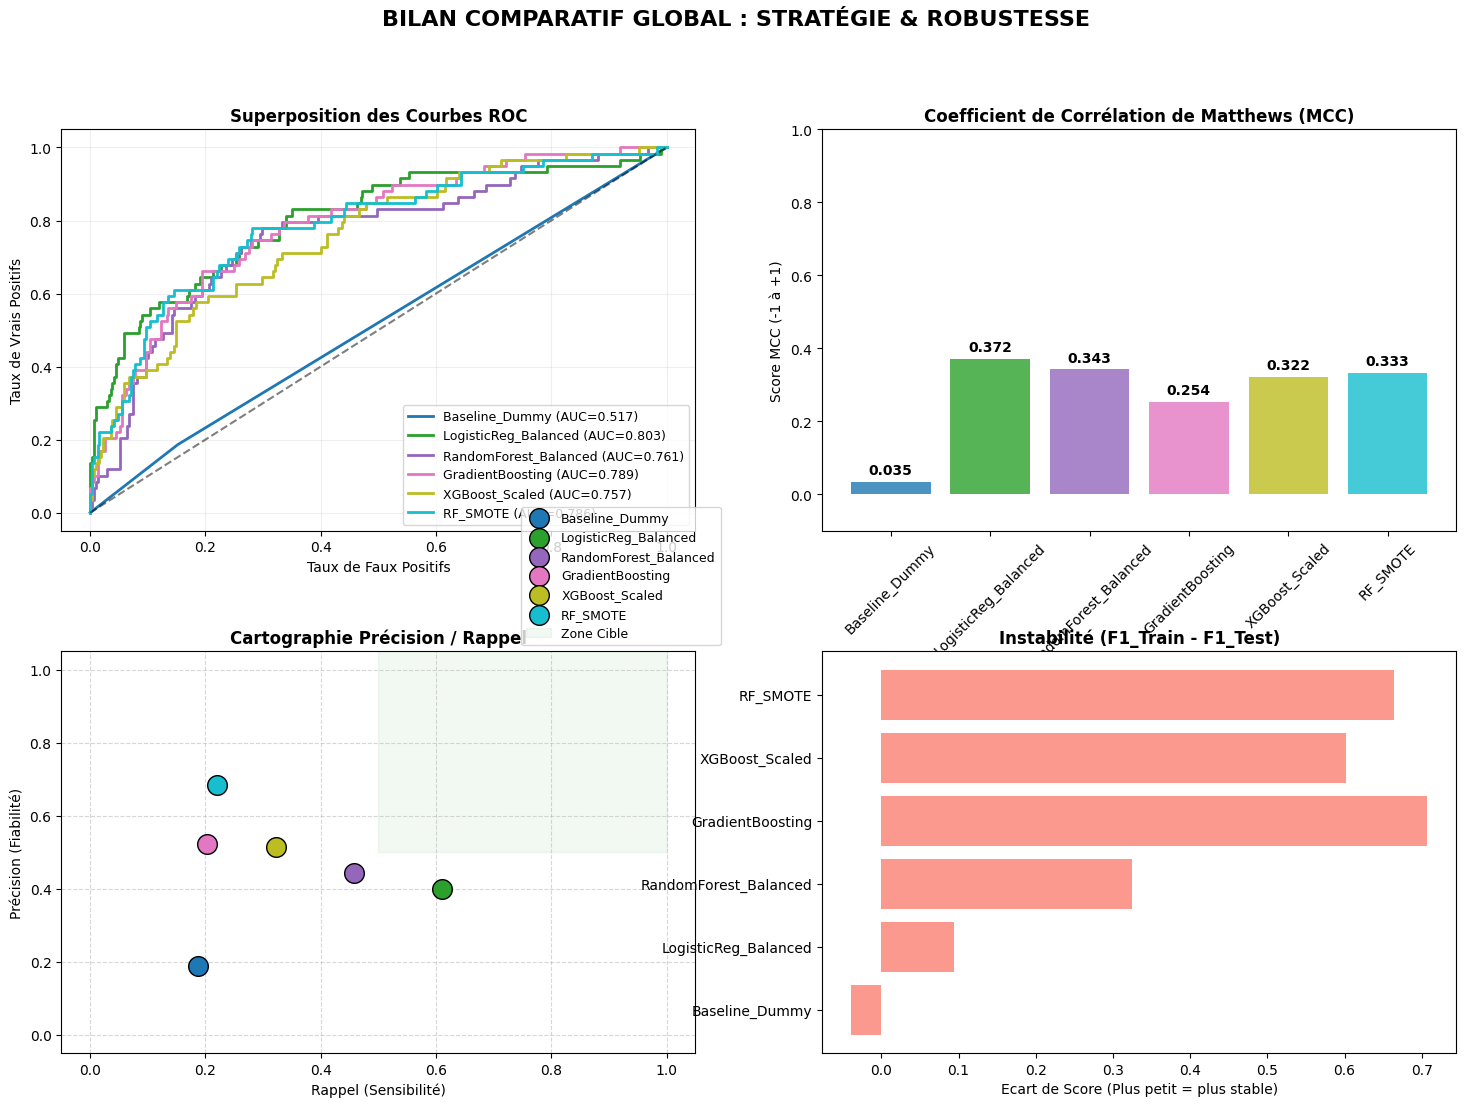

In [134]:
# 5. Visualisations Diagnostiques
# --------------------------------------------------------------------------
# Appel de la visualisation comparative avancée
modeler.visualiser_comparaison_avancee(taille_fig=(18, 12))

### 📈 Tableau Comparatif Global

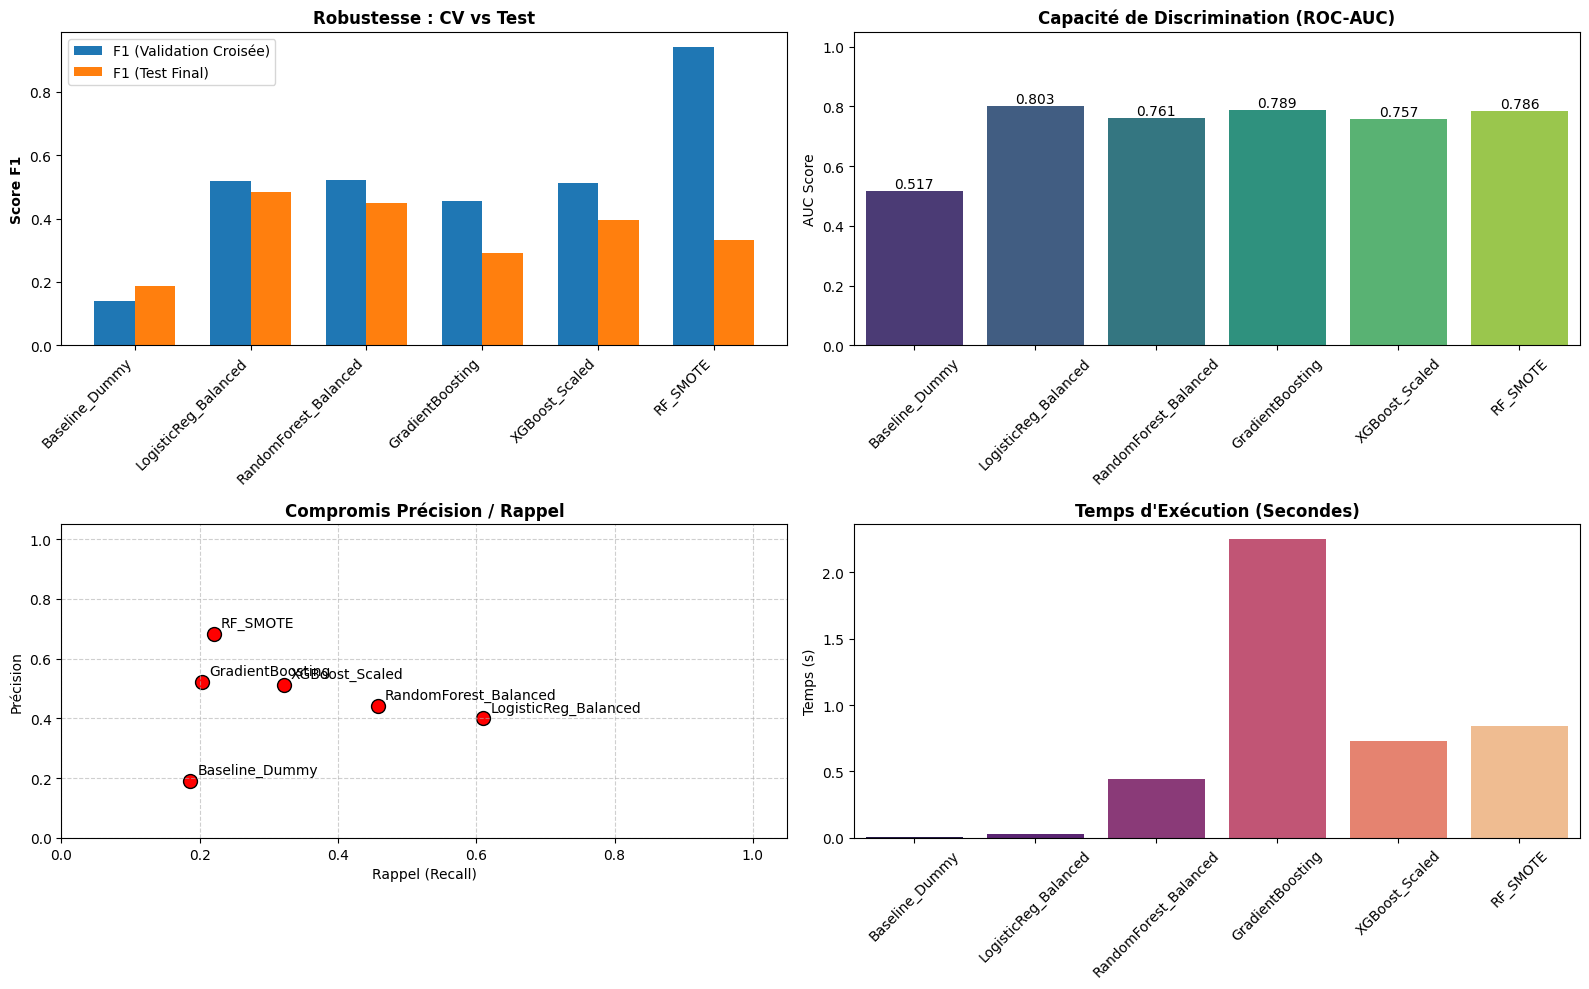

In [135]:
modeler.visualiser_comparaison()

## Etude Individuels

### 📈 Evaluation Meileur Modele 🏆 'Regression_Logistique' (LogisticRegression)

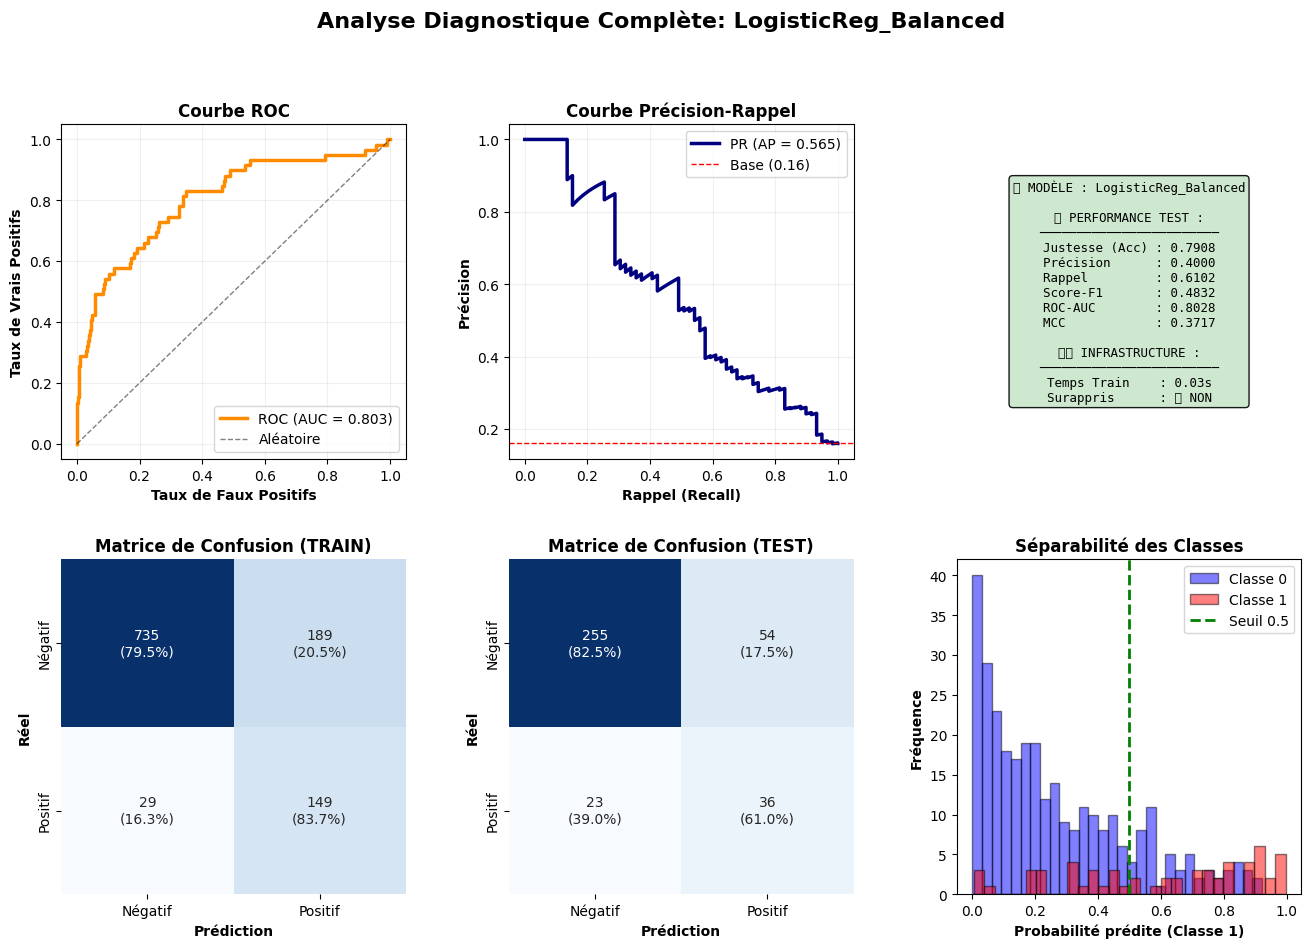

In [136]:
modeler.visualiser_meilleur_modele()

# 🎓 Step 5.  Optimisation

## Identification seuil optimal

In [137]:
# Extraction des données du meilleur modèle
nom, instance, resultats_complets = modeler.obtenir_meilleur_modele()

print(f"🚀 Modèle récupéré : {nom}")

# Récupération des probabilités sur le jeu de test
y_proba = resultats_complets['predictions']['y_test_proba']
y_reel  = modeler.y_test

🚀 Modèle récupéré : LogisticReg_Balanced


In [138]:
from sklearn.metrics import f1_score, recall_score, precision_score

def trouver_seuil_optimal(y_true, y_probs):
    meilleur_seuil = 0.5
    meilleur_f1    = 0
    
    # On teste 100 seuils différents entre 0.1 et 0.9
    for seuil in np.linspace(0.1, 0.9, 100):
        y_pred = (y_probs >= seuil).astype(int)
        score  = f1_score(y_true, y_pred)
        
        if score > meilleur_f1:
            meilleur_f1    = score
            meilleur_seuil = seuil
            
    return meilleur_seuil

# Calcul du nouveau seuil
seuil_opti = trouver_seuil_optimal(y_reel, y_proba)
print(f"💡 Seuil optimal trouvé : {seuil_opti:.2f}")

💡 Seuil optimal trouvé : 0.72


In [139]:
# 1. Récupérer le modèle et les probabilités
nom, instance, res = modeler.obtenir_meilleur_modele()
y_proba = res['predictions']['y_test_proba']

# 2. Appliquer le nouveau seuil (0.72)
seuil_custom = seuil_opti
y_pred_custom = (y_proba >= seuil_custom).astype(int)

# 3. Afficher le nouveau bilan
print(f"✨ Nouveau bilan pour {nom} (Seuil {seuil_custom}) :")
print(classification_report(modeler.y_test, y_pred_custom))

# PREALABLEMENT
# ──────────────────────────────────────────────────────────────────────
# 📊 RAPPORT DE CLASSIFICATION (LogisticReg_Balanced)
# ──────────────────────────────────────────────────────────────────────
#               precision    recall  f1-score   support
# 
#            0       0.92      0.83      0.87       309
#            1       0.40      0.61      0.48        59
# 
#     accuracy                           0.79       368
#    macro avg       0.66      0.72      0.68       368
# weighted avg       0.83      0.79      0.81       368

✨ Nouveau bilan pour LogisticReg_Balanced (Seuil 0.7222222222222222) :
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       309
           1       0.62      0.49      0.55        59

    accuracy                           0.87       368
   macro avg       0.76      0.72      0.74       368
weighted avg       0.86      0.87      0.86       368



## 📈 Visualisation Finale : Le "Avant / Après"

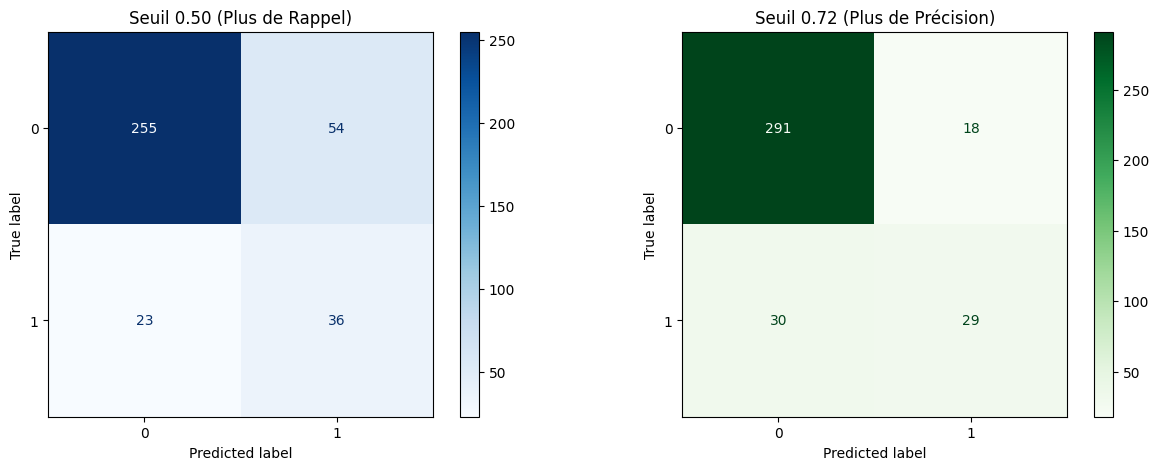

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul des deux versions
y_pred_05  = (y_proba >= 0.5).astype(int)
y_pred_072 = (y_proba >= 0.727).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Matrice à 0.5
ConfusionMatrixDisplay.from_predictions(modeler.y_test, y_pred_05, ax=ax[0], cmap='Blues')
ax[0].set_title("Seuil 0.50 (Plus de Rappel)")

# Matrice à 0.727
ConfusionMatrixDisplay.from_predictions(modeler.y_test, y_pred_072, ax=ax[1], cmap='Greens')
ax[1].set_title(f"Seuil {seuil_opti:.2f} (Plus de Précision)")

plt.show()

## Calcul de l'AUC-PR

In [141]:
# 4. Calcul de l'AUC-PR
ap_score = average_precision_score(modeler.y_test, y_proba)
print(f"🎯 PR-AUC (Average Precision) : {ap_score:.4f}")

🎯 PR-AUC (Average Precision) : 0.5649


## Analyser feature importance (permutation)

🔄 Calcul de la Permutation Importance (f2) pour LogisticReg_Balanced...


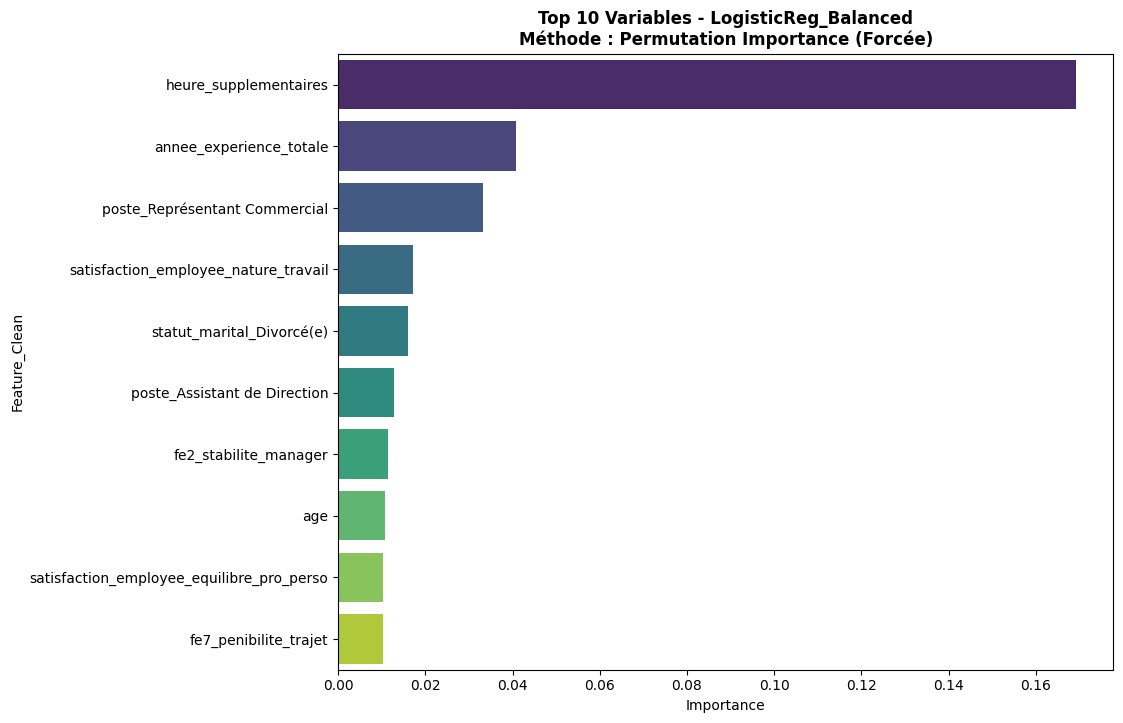

🏆 TOP 10 DES VARIABLES DÉTERMINANTES
----------------------------------------
1. heure_supplementaires (0.1693)
2. annee_experience_totale (0.0407)
3. poste_Représentant Commercial (0.0332)
4. satisfaction_employee_nature_travail (0.0170)
5. statut_marital_Divorcé(e) (0.0159)
6. poste_Assistant de Direction (0.0128)
7. fe2_stabilite_manager (0.0113)
8. age (0.0108)
9. satisfaction_employee_equilibre_pro_perso (0.0102)
10. fe7_penibilite_trajet (0.0102)
['n_std__heure_supplementaires', 'n_log__annee_experience_totale', 'c_ohe__poste_Représentant Commercial', 'n_std__satisfaction_employee_nature_travail', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__poste_Assistant de Direction', 'fe2_stabilite_manager', 'n_std__age', 'n_std__satisfaction_employee_equilibre_pro_perso', 'fe7_penibilite_trajet']


In [142]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, fbeta_score
def analyser_importance_features_by_method(nom_modele=None, X=None, y=None, top_n=15, method='auto', scoring='f1'):
    """
    Analyse l'importance des variables avec priorité configurable.
    
    Arguments:
    ----------
    method : 'auto'       -> Utilise native si disponible, sinon permutation.
             'permutation'-> FORCE le calcul par permutation (idéal pour modèles linéaires).
             'native'     -> FORCE l'utilisation de coef_ ou feature_importances_.
    """
    # 1. Récupération du modèle (Logique inchangée)
    if nom_modele is None:
        nom, instance, res = modeler.obtenir_meilleur_modele()
    else:
        nom = nom_modele
        instance, res = modeler.obtenir_modele(nom)

    features = X.columns if X is not None else X_train.columns
    importances = None
    type_imp = ""

    # 2. Logique de décision (Modifiée pour donner la priorité à la méthode choisie)
    
    # CAS FORCE : PERMUTATION
    if method == 'permutation':
        if X is not None and y is not None:
            f2_scorer      = make_scorer(fbeta_score, beta=2, zero_division=0)
            actual_scoring = f2_scorer if scoring == 'f2' else scoring
            
            print(f"🔄 Calcul de la Permutation Importance ({scoring}) pour {nom}...")
            
            r = permutation_importance(
                instance, X, y, 
                n_repeats     = 3, 
                scoring       = actual_scoring, # Aquí pasamos el objeto f2_scorer o el string 'f1'
                random_state  = 42, 
                n_jobs        = -1
            )
            importances = r.importances_mean
            type_imp = "Permutation Importance (Forcée)"
        else:
            print("❌ Erreur: X et y sont requis pour la permutation.")
            return None

    # CAS NATIVE (ou AUTO si permutation n'est pas forcée)
    if importances is None:
        if hasattr(instance, 'feature_importances_') and method != 'permutation':
            importances = instance.feature_importances_
            type_imp = "Native (Gini/Gain)"
        elif hasattr(instance, 'coef_') and method != 'permutation':
            importances = np.abs(instance.coef_[0])
            type_imp = "Coefficients (Magnitude)"

    # 3. Finalisation (DataFrame et Plot)
    if importances is None:
        print(f"⚠️ Impossible d'extraire l'importance pour {nom} avec la méthode {method}")
        return None

    df_imp                  = pd.DataFrame({'Feature': features, 'Importance': importances})
    df_imp['Feature_Clean'] = df_imp['Feature'].str.replace(r'c_ohe__|n_std__|n_log__|__', ' ', regex=True).str.strip()
    df_imp                  = df_imp.sort_values(by='Importance', ascending=False).head(top_n)

    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature_Clean', data=df_imp, palette='viridis')
    plt.title(f'Top {top_n} Variables - {nom}\nMéthode : {type_imp}', fontweight='bold')
    plt.show()

    return df_imp
# -----------------------------------------------------------------------------
# TEXTE

# Esto ignorará los coeficientes y calculará el impacto real en el set de Test
top_N_features = analyser_importance_features_by_method(
    X=X_test, 
    y=y_test, 
    top_n=10,
    scoring='f2',
    method='permutation'
)

print("🏆 TOP 10 DES VARIABLES DÉTERMINANTES")
print("-" * 40)
for i, row in enumerate(top_N_features.itertuples(), 1):
    print(f"{i}. {row.Feature_Clean} ({row.Importance:.4f})")

# Stocker la liste des noms pour plus tard
liste_top_10 = top_N_features['Feature'].tolist()

# -----------------------------------------------------------------------------
# GRAPHIQUE
# Exécution de l'analyse

print(list(top_N_features['Feature'].values))

## 📈 Visualiser_modele avec seuil optime 

✅ Seuil de 0.72 enregistré pour LogisticReg_Balanced


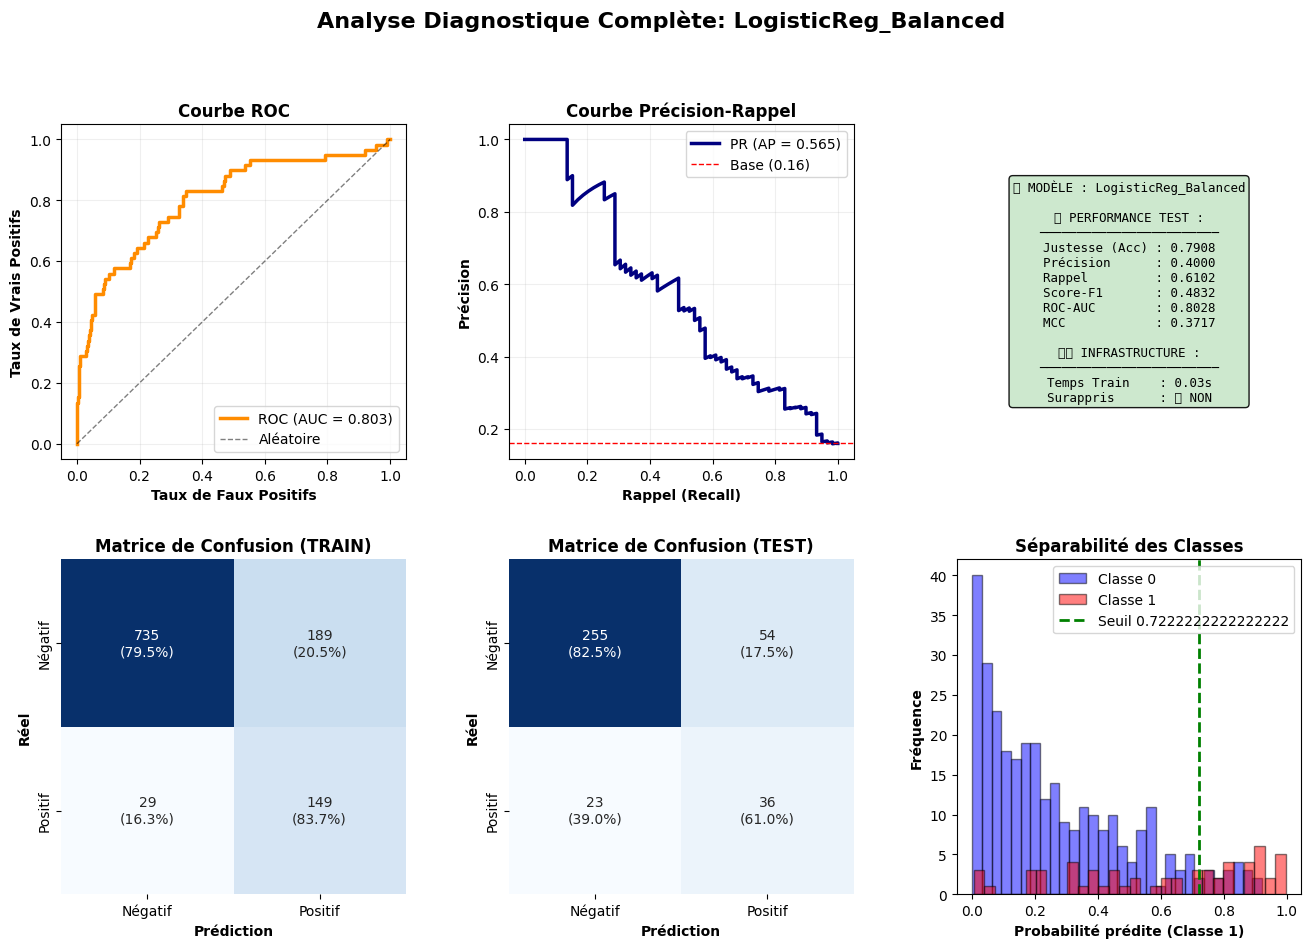

In [143]:
# 1. On informe le modeler du nouveau seuil stratégique
nombre_modelo, instance, resultats_complets = modeler.obtenir_meilleur_modele()

if nombre_modelo in modeler.historique_resultats:
    modeler.historique_resultats[nombre_modelo]['seuil_optimal'] = seuil_opti
    print(f"✅ Seuil de {seuil_opti:.2f} enregistré pour {nombre_modelo}")

# 2. On relance la visualisation 
# (Il faut que ta fonction visualiser_modele soit codée pour lire cette valeur)
modeler.visualiser_modele(nombre_modelo)

## 📈 Analyse de la distribution des probabilités (VP, FP, FN, VN)

In [144]:
# Création d'un DataFrame d'analyse
df_analyse = modeler.predire_probabilites(nombre_modelo)
df_analyse['vrai_y'] = modeler.y_test.values

# Categorisation y visualisation
def categoriser(row):
    if row['vrai_y'] == 1 and row['pred'] == 1: return 'VP (Succès)'
    if row['vrai_y'] == 0 and row['pred'] == 1: return 'FP (Fausse Alerte)'
    if row['vrai_y'] == 1 and row['pred'] == 0: return 'FN (Manqué)'
    return 'VN (Correct)'

df_analyse['categorie'] = df_analyse.apply(categoriser, axis=1)
df_analyse

,proba,pred,vrai_y,categorie
1307,0.094365,0,0,VN (Correct)
1190,0.015376,0,0,VN (Correct)
1026,0.134881,0,0,VN (Correct)
1212,0.220096,0,0,VN (Correct)
551,0.560787,1,0,FP (Fausse Alerte)
...,...,...,...,...
581,0.253532,0,0,VN (Correct)
577,0.453069,0,0,VN (Correct)
843,0.088286,0,0,VN (Correct)
1397,0.082787,0,0,VN (Correct)


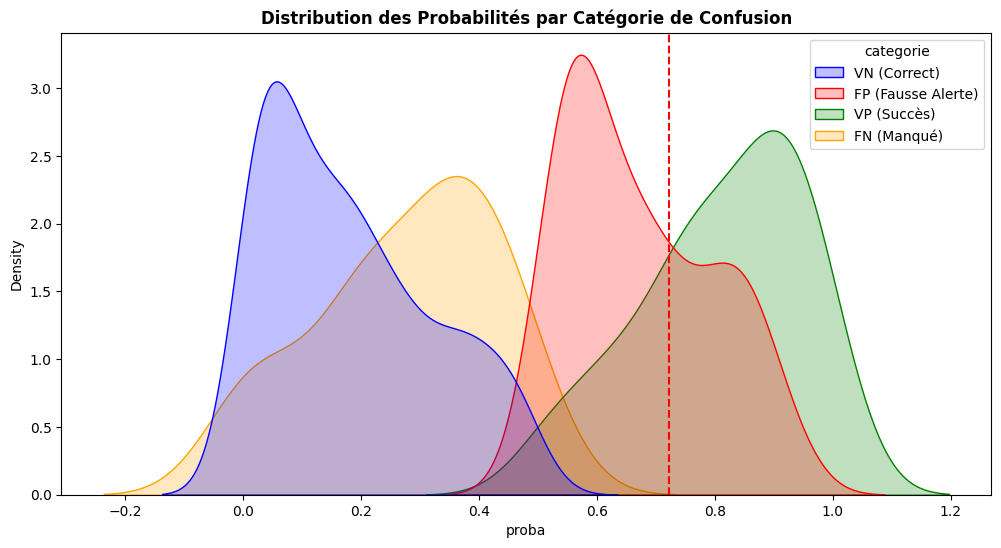

In [145]:
# Visualisation
palette_metier = {
    'VP (Succès)': 'green',
    'FP (Fausse Alerte)': 'red',
    'FN (Manqué)': 'orange',
    'VN (Correct)': 'blue'
}

plt.figure(figsize=(12, 6))
sns.kdeplot( data=df_analyse, 
            x='proba', 
             hue='categorie', 
             fill=True, 
             common_norm=False, 
             # palette='viridis'
             palette=palette_metier
           )
plt.axvline(seuil_custom, color='red', linestyle='--', label=f'Seuil {seuil_custom:.2f}')
plt.title("Distribution des Probabilités par Catégorie de Confusion", fontweight='bold')
plt.show()

## Identifier les zones de confiance (ex: prob > 85%)

### Vérifier volume de prédictions fiables suffisant (Analyse du Taux de Couverture)

In [146]:
# 1. Definimos el umbral de alta confianza de forma explícita
SEUIL_HAUTE_CONFIANCE = 0.85 

# 2. FILTRAR usando el umbral de alta confianza, NO el óptimo
zone_critique = df_analyse[df_analyse['proba'] >= SEUIL_HAUTE_CONFIANCE]

# 3. Recalcular métricas sobre esta zona específica
total_departs_reels       = modeler.y_test.sum()
vrais_positifs_critiques  = zone_critique['vrai_y'].sum()
nb_alertes                = len(zone_critique)

# Taux de couverture (Recall en esta zona)
taux_couverture           = (vrais_positifs_critiques / total_departs_reels) * 100

# Fiabilidad (Precisión en esta zona)
# Nota: Usamos 'pred' si ya está ajustado a este umbral, 
# pero lo más seguro en esta zona es que todos se consideren "1"
precision_haute_confiance = vrais_positifs_critiques / nb_alertes if nb_alertes > 0 else 0
fiabilite                 = precision_haute_confiance * 100

ratio_succes = round(precision_haute_confiance * 10)

print("="*80)
print(f"📢 RÉSUMÉ POUR LA DIRECTION RH (ZONE CRITIQUE)")
print(f"Seuil de confiance appliqué : {SEUIL_HAUTE_CONFIANCE*100}%")
print("-" * 80)
print(f"✅ Départs réels identifiés en test          : {total_departs_reels}")
print(f"🔥 Alertes de haute priorité générées        : {nb_alertes}")
print(f"🎯 Départs réels capturés (Haut Risque)      : {vrais_positifs_critiques}")
print(f"📈 Taux de couverture de la zone             : {taux_couverture:.2f}%")
print(f"✅ Fiabilité / Précision de l'alerte         : {fiabilite:.2f}%")
print(f"👉 Interprétation : Sur 10 alertes émises    : {ratio_succes} départs effectifs")
print(f"🚀 Action : {nb_alertes} entretiens prioritaires à mener immédiatement.")
print("="*80)

📢 RÉSUMÉ POUR LA DIRECTION RH (ZONE CRITIQUE)
Seuil de confiance appliqué : 85.0%
--------------------------------------------------------------------------------
✅ Départs réels identifiés en test          : 59
🔥 Alertes de haute priorité générées        : 22
🎯 Départs réels capturés (Haut Risque)      : 17
📈 Taux de couverture de la zone             : 28.81%
✅ Fiabilité / Précision de l'alerte         : 77.27%
👉 Interprétation : Sur 10 alertes émises    : 8 départs effectifs
🚀 Action : 22 entretiens prioritaires à mener immédiatement.


Capturer un <span style="color:red"> TAUX_DE_COVERTURE de **28,81 %** </span>des départs avec une précision <span style="color:red"> PRECISION_FIABILITE_CERTITUDE de **77 %** </span> est un succès stratégique.

Ce mieux un modèle qui capture **30 % des fautifs avec 80 % de certitude**, 
      qu'un modèle qui capture **80 % des fautifs avec 30 % de certitude**.

* Dans le premier cas (le vôtre), c'est comme un expert qui donne des conseils précis.
* Dans le second cas, c'est comme une alarme qui sonne tout le temps pour rien : les RH finiront par ignorer le modèle.


### Analyser les Faux Négatifs (FN) : Hésitants vs Très Confiants

Reste à comprendre pourquoi le modèle a ignoré les **42 départs restants** (59 réels - 17 capturés).

* **Sont-ils des "Hésitants" ?** (Proba entre 0.40 et 0.72) -> Le modèle a vu un signal mais a manqué d'audace.
* **Sont-ils des "Indétectables" ?** (Proba < 0.20) -> Le modèle est passé totalement à côté.


In [147]:
# 1. Fuente única de verdad
SEUIL_HAUTE_CONFIANCE = 0.85 

# 2. Segmentación de los départs réels
departs_reels = df_analyse[df_analyse['vrai_y'] == 1].copy()

def segmenter_total_departs(p):
    # Usamos la constante definida arriba
    if p >= SEUIL_HAUTE_CONFIANCE: 
        return f"0. ZONE CRITIQUE (Hauts Risques)...(Score: > {SEUIL_HAUTE_CONFIANCE:.2f})"
    if p >= 0.72: # Umbral óptimo F2
        return f"1. ZONE OPTIMALE (Détectés)........(Score: 0.72 - {SEUIL_HAUTE_CONFIANCE:.2f})"
    if p >= 0.50: 
        return  "2. Hésitants (Manqués).............(Score: 0.50 - 0.72)"
    if p >= 0.20: 
        return  "3. Signaux Faibles (Manqués).......(Score: 0.20 - 0.50)"
    return      "4. Invisibles (Cygnes Noirs).......(Score: < 0.20)"

departs_reels['segment'] = departs_reels['proba'].apply(segmenter_total_departs)

# 3. Cálculos para el resumen de RH (usando la misma lógica)
zone_critique = df_analyse[df_analyse['proba'] >= SEUIL_HAUTE_CONFIANCE]
nb_alertes = len(zone_critique)
vrais_positifs_critiques = zone_critique['vrai_y'].sum()
precision_hc = vrais_positifs_critiques / nb_alertes if nb_alertes > 0 else 0

# 4. Impresión del Bilan
print(f"📊 BILAN GLOBAL COHÉRENT (Seuil: {SEUIL_HAUTE_CONFIANCE})")
print("-" * 75)
bilan_total = departs_reels['segment'].value_counts().sort_index()
for segment, count in bilan_total.items():
    perc = (count / len(departs_reels)) * 100
    barre = "█" * int(perc / 5)
    print(f"{segment:<55} | {count:>3} emp. ({perc:>5.1f}%) {barre}")
print("-" * 75)

# 5. Resumen Ejecutivo
print(f"📢 RÉSUMÉ DIRECTION (Fiabilité confirmée: {precision_hc:.1%})")
print(f"Sur {nb_alertes} alertes émises à >{SEUIL_HAUTE_CONFIANCE:.2f}, {vrais_positifs_critiques} sont des départs réels.")

📊 BILAN GLOBAL COHÉRENT (Seuil: 0.85)
---------------------------------------------------------------------------
0. ZONE CRITIQUE (Hauts Risques)...(Score: > 0.85)      |  17 emp. ( 28.8%) █████
1. ZONE OPTIMALE (Détectés)........(Score: 0.72 - 0.85) |  12 emp. ( 20.3%) ████
2. Hésitants (Manqués).............(Score: 0.50 - 0.72) |   7 emp. ( 11.9%) ██
3. Signaux Faibles (Manqués).......(Score: 0.20 - 0.50) |  16 emp. ( 27.1%) █████
4. Invisibles (Cygnes Noirs).......(Score: < 0.20)      |   7 emp. ( 11.9%) ██
---------------------------------------------------------------------------
📢 RÉSUMÉ DIRECTION (Fiabilité confirmée: 77.3%)
Sur 22 alertes émises à >0.85, 17 sont des départs réels.


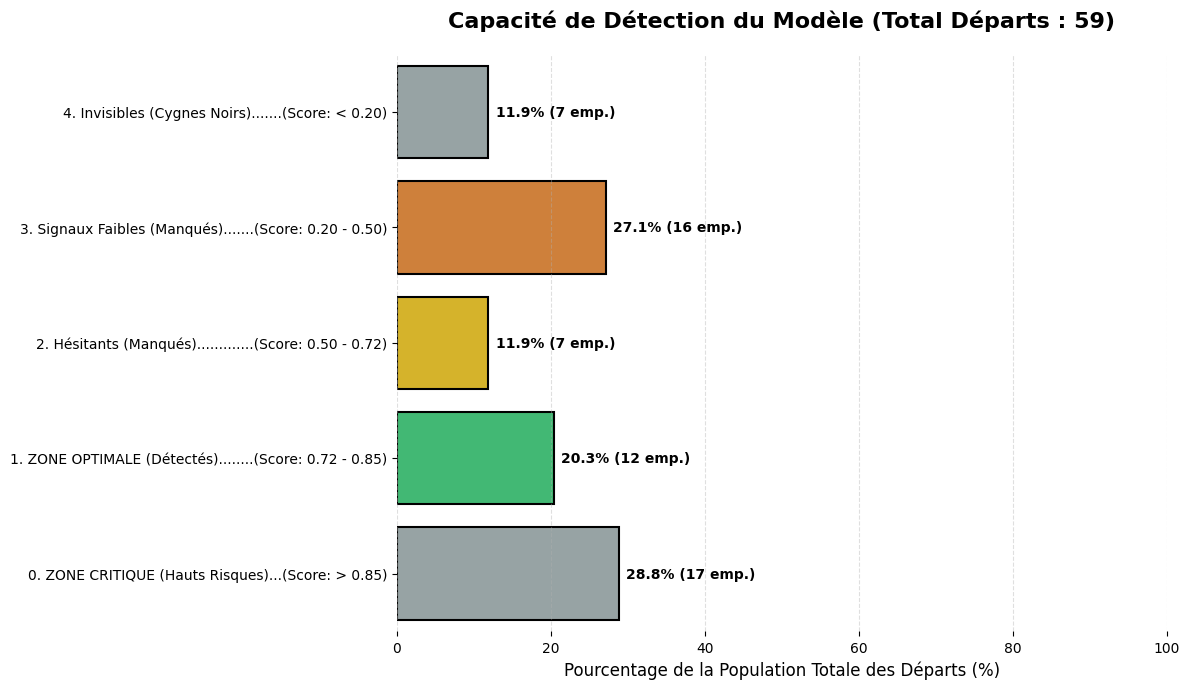

In [148]:
# 1. Preparar los datos del gráfico
data_plot = departs_reels['segment'].value_counts().sort_index(ascending=False).reset_index()
data_plot.columns = ['Segment', 'Nombre d\'employés']
data_plot['Pourcentage'] = (data_plot['Nombre d\'employés'] / len(departs_reels)) * 100

# 2. Definir una paleta de colores semántica
# Verde para el éxito, amarillos/naranjas para las dudas, gris/rojo para lo invisible
colores = ["#2ecc71", "#f1c40f", "#e67e22", "#95a5a6"] 

# 3. Crear la figura
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Pourcentage', 
    y='Segment', 
    data=data_plot, 
    palette=colores[::-1], # Invertimos para que coincida con el orden de los segmentos
    edgecolor="black",
    linewidth=1.5
)

# 4. Añadir etiquetas de texto sobre las barras
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(
        width + 1, 
        p.get_y() + p.get_height()/2, 
        f"{width:.1f}% ({data_plot.iloc[i]['Nombre d\'employés']} emp.)", 
        va='center', 
        fontweight='bold'
    )

# 5. Personalización estética (Nivel Pro)
plt.title(f"Capacité de Détection du Modèle (Total Départs : {len(departs_reels)})", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Pourcentage de la Population Totale des Départs (%)", fontsize=12)
plt.ylabel("")
plt.xlim(0, 100) # El total es siempre 100%
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [149]:
# 2. Isoler les Faux Négatifs
fn = df_analyse[(df_analyse['vrai_y'] == 1) & (df_analyse['pred'] == 0)].copy()

# 3. Créer les segments avec le détail du "margen" (rango)
def segmenter_fn(p):
    if p >= 0.50: return f"1. Hésitants...................(Marge: 0.50 - {seuil_actuel})"
    if p >= 0.20: return  "2. Signaux Faibles.............(Marge: 0.20 - 0.50)"
    return                "3. Invisibles / Cygnes Noirs...(Marge: < 0.20)"

fn['segment'] = fn['proba'].apply(segmenter_fn)

# 4. Bilan chiffré et calcul des pourcentages
bilan_fn = fn['segment'].value_counts().sort_index()
total_fn = len(fn)

print(f"📉 ANALYSE DES {total_fn} DÉPARTS MANQUÉS (FN)")
print(f"Critère: Employés qui sont partis mais avec un score < {seuil_opti}")
print("-" * 55)

for segment, count in bilan_fn.items():
    pourcentage = (count / total_fn) * 100
    print(f"{segment:<55} | {count:>3} employés ({pourcentage:>5.1f}%)")

print("-" * 55)

📉 ANALYSE DES 23 DÉPARTS MANQUÉS (FN)
Critère: Employés qui sont partis mais avec un score < 0.7222222222222222
-------------------------------------------------------
2. Signaux Faibles.............(Marge: 0.20 - 0.50)     |  16 employés ( 69.6%)
3. Invisibles / Cygnes Noirs...(Marge: < 0.20)          |   7 employés ( 30.4%)
-------------------------------------------------------


In [150]:
# 1. Isoler les Faux Négatifs (Partis mais non détectés par le seuil 0.72)
fn = df_analyse[(df_analyse['vrai_y'] == 1) & (df_analyse['pred'] == 0)].copy()

# 2. Créer les segments
def segmenter_fn(p):
    if p >= 0.50: return "1. Hésitants (Presque détectés)"
    if p >= 0.20: return "2. Signaux Faibles"
    return "3. Invisibles (Cygnes Noirs)"

fn['segment'] = fn['proba'].apply(segmenter_fn)

# 3. Bilan chiffré
bilan_fn = fn['segment'].value_counts().sort_index()
print("📉 ANALYSE DES 42 DÉPARTS MANQUÉS")
print("-" * 40)
print(bilan_fn)

📉 ANALYSE DES 42 DÉPARTS MANQUÉS
----------------------------------------
segment
2. Signaux Faibles              16
3. Invisibles (Cygnes Noirs)     7
Name: count, dtype: int64


* **Les Hésitants (Proba > 0.50) :** Ce sont les victoires faciles. Le modèle les avait identifiés comme "à risque" avec le seuil par défaut, mais le seuil de sécurité (0.72) les a écartés pour éviter les fausses alertes.
    * *Conseil RH :* Si l'entreprise a du budget, on peut baisser un peu le seuil pour inclure ce groupe.

* **Les Signaux Faibles (0.20 - 0.50) :** Ici, le modèle a détecté une anomalie (ex: une légère baisse de satisfaction), mais pas assez pour compenser un salaire élevé ou une grande ancienneté.
    * *Analyse d'expert :* C'est ici que nos nouvelles variables **`fe_`** travaillent, mais elles sont en compétition avec des variables "ancres" qui rassurent le modèle.

* **Les Invisibles (Proba < 0.20) :** Ce sont les départs les plus frustrants. L'employé semble parfaitement heureux et stable dans les données, mais il part quand même.
    * *Leçon:* L'IA a des limites éthiques et de données. Sans accès aux emails ou aux sentiments réels (non déclarés), ces départs resteront imprévisibles.


In [151]:
fn_graves = df_analyse[(df_analyse['categorie'] == 'FN (Manqué)')].sort_values(by='proba')
print("⚠️ Top 5 des Faux Négatifs les plus 'indétectables' (Proba très basse) :")
print(fn_graves.head(5))

⚠️ Top 5 des Faux Négatifs les plus 'indétectables' (Proba très basse) :
         proba  pred  vrai_y    categorie
1111  0.005672     0       1  FN (Manqué)
126   0.013201     0       1  FN (Manqué)
928   0.021401     0       1  FN (Manqué)
45    0.055252     0       1  FN (Manqué)
229   0.173669     0       1  FN (Manqué)


**L'Échec du Signal (Lignes 1111, 126, 928)**

Regardez l'employé 1111 : sa probabilité est de 0.005 ($0.5\%$). 
* Pour le modèle, il est "pratiquement impossible" que cette personne parte. 
* Pourtant, elle est partie (vrai_y = 1).

**Ligne 229 : Avec 0.17**

On commence à sortir du "bruit" total. Le modèle commence à voir quelque chose, même si c'est encore très loin du seuil de décision ($0.72$).

# 👥 Step 6. Extraire la "Liste d'Intervention"

In [152]:
top_N_features

,Feature,Importance,Feature_Clean
13,n_std__heure_supplementaires,0.169334,heure_supplementaires
1,n_log__annee_experience_totale,0.040730,annee_experience_totale
30,c_ohe__poste_Représentant Commercial,0.033157,poste_Représentant Commercial
9,n_std__satisfaction_employee_nature_travail,0.017045,satisfaction_employee_nature_travail
23,c_ohe__statut_marital_Divorcé(e),0.015900,statut_marital_Divorcé(e)
25,c_ohe__poste_Assistant de Direction,0.012755,poste_Assistant de Direction
44,fe2_stabilite_manager,0.011347,fe2_stabilite_manager
4,n_std__age,0.010784,age
11,n_std__satisfaction_employee_equilibre_pro_perso,0.010243,satisfaction_employee_equilibre_pro_perso
49,fe7_penibilite_trajet,0.010237,fe7_penibilite_trajet


In [153]:
# 1. Identifier les N variables les plus importantes globalement
# (Basé sur top_N_features obtenu de l'analyse de feature importance faite précédemment)

# Tomamos los primeros 7 elementos de la lista
top_P_list = top_N_features['Feature'].tolist()[:7]

# 2. Construire la table de diagnostic pour la Zone Critique (> 85%)
indices_critiques = df_analyse[df_analyse['proba'] > 0.85].index

# On combine l'ID, la Probabilité et les valeurs des Top Features
tableau_rh = pd.DataFrame({
    'Probabilité (%)': (df_analyse.loc[indices_critiques, 'proba'] * 100).round(1)
}, index=indices_critiques)

# Ajout des données des top features pour ces employés
tableau_rh = pd.concat([tableau_rh, X_test.loc[indices_critiques, top_P_list ]], axis=1)

# 3. Trier et afficher
tableau_rh = tableau_rh.sort_values(by='Probabilité (%)', ascending=False)

# 1. Créer une copie du tableau pour ne pas casser le code ailleurs
tableau_final = tableau_rh.copy()

# 2. Nettoyer les noms de colonnes
# On retire 'c_ohe__', 'n_std__' et on remplace les doubles underscores par des espaces
nouveaux_noms = (tableau_final.columns.str.replace('c_ohe__', '', regex=False)
                                     .str.replace('n_std__', '', regex=False)
                                     .str.replace('n_log__', '', regex=False)
                                     .str.replace('__', ' ', regex=False))
                                     # .str.replace('_', ' ', regex=False))

tableau_final.columns = nouveaux_noms

# 3. Affichage propre
print(f"📋 LISTE D'INTERVENTION RH (Noms nettoyés)")
print("-" * 110)
print(tableau_final.to_string())

📋 LISTE D'INTERVENTION RH (Noms nettoyés)
--------------------------------------------------------------------------------------------------------------
      Probabilité (%)  heure_supplementaires  annee_experience_totale  poste_Représentant Commercial  satisfaction_employee_nature_travail  statut_marital_Divorcé(e)  poste_Assistant de Direction  fe2_stabilite_manager
911              99.6               1.591746                -2.351758                            1.0                              1.153254                        0.0                           0.0               6.893396
1379             99.0              -0.628241                -2.351758                            0.0                             -0.660853                        0.0                           0.0               6.893396
357              98.9               1.591746                -1.336613                            1.0                             -0.660853                        0.0                         

🎓 Step 8. Optimisation 2. Train a Model simplified

# 💾 Step 7. Sauvegarde (joblib)

## Sauvegarde de tous les modeles 

In [154]:
modeler.sauvegarder_modele(MODEL_DummyClassifier            , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_LogisticRegression         , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_RandomForestClassifier     , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_GradientBoostingClassifier , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_XGBClassifier              , MODELS_DIR)

if strategie_recommandee == "aggressive":
    modeler.sauvegarder_modele(MODEL_RandomForestClassifier_SMOTE , MODELS_DIR)

💾 Modèle 'Baseline_Dummy                     ' sauvegardé sous : ..\models\V2\Baseline_Dummy.joblib
💾 Modèle 'LogisticReg_Balanced               ' sauvegardé sous : ..\models\V2\LogisticReg_Balanced.joblib
💾 Modèle 'RandomForest_Balanced              ' sauvegardé sous : ..\models\V2\RandomForest_Balanced.joblib
💾 Modèle 'GradientBoosting                   ' sauvegardé sous : ..\models\V2\GradientBoosting.joblib
💾 Modèle 'XGBoost_Scaled                     ' sauvegardé sous : ..\models\V2\XGBoost_Scaled.joblib
💾 Modèle 'RF_SMOTE                           ' sauvegardé sous : ..\models\V2\RF_SMOTE.joblib


In [155]:
# Also
modeler.sauvegarder_tous_les_modeles(MODELS_DIR)

💾 Modèle 'Baseline_Dummy                     ' sauvegardé sous : ..\models\V2\Baseline_Dummy.joblib
💾 Modèle 'LogisticReg_Balanced               ' sauvegardé sous : ..\models\V2\LogisticReg_Balanced.joblib
💾 Modèle 'RandomForest_Balanced              ' sauvegardé sous : ..\models\V2\RandomForest_Balanced.joblib
💾 Modèle 'GradientBoosting                   ' sauvegardé sous : ..\models\V2\GradientBoosting.joblib
💾 Modèle 'XGBoost_Scaled                     ' sauvegardé sous : ..\models\V2\XGBoost_Scaled.joblib
💾 Modèle 'RF_SMOTE                           ' sauvegardé sous : ..\models\V2\RF_SMOTE.joblib
✅ 6 modèles ont été sauvegardés avec succès.


## Sauvegarde du meilleur modele

In [156]:
import joblib

# On cree un paquet complet avec le principal elements
# On identifie les elements
nom, classifier_instance, resultats_complets = modeler.obtenir_meilleur_modele()

# Créer un pack complet
export_data = {
    'nom'       : nom,
    'modele'    : classifier_instance,
    'resultats' : resultats_complets,
}

output_path = MODELS_DIR / "0_BEST_MODEL_PACK.joblib"

# Sauvegarder le pack
joblib.dump(export_data, output_path)

['..\\models\\V2\\0_BEST_MODEL_PACK.joblib']

## Sauvegarde des datasets used as Train/Test

In [157]:
data_bundle = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

joblib.dump(data_bundle, MODELS_DIR / "split_data_attrition.joblib", compress=3)
print("✅ Datos split saved.")

✅ Datos split saved.
